**BASIC**

In [729]:
import os
#import gym
#import math
#import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#import datetime
#from dateutil.relativedelta import relativedelta   #for leaping forward by 1 year
#from collections import namedtuple, deque
from itertools import count
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels.regression.linear_model import OLS

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [39]:
#function for saving trained models in a folder
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [ ]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

**DATA PIPELINE**

In [61]:
import data_pipeline as pipeline
import config
pgConnStr = config.pgDictToConn(config.pgSecrets)

In [62]:
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)

In [67]:
n_clusters = 10

In [68]:
clusters = pipeline.findStockClusters(dailyDF, n_clusters)

/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [69]:
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)

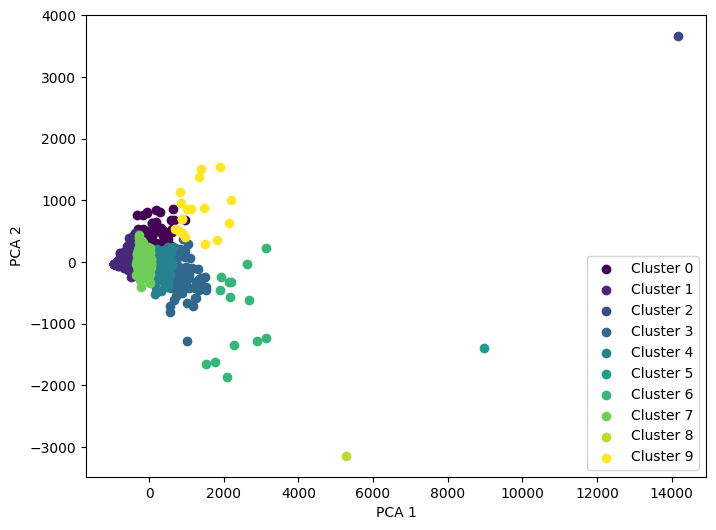

In [70]:
pipeline.plotStockClusters(clusters)

In [49]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline
import config

pgConnStr = config.pgDictToConn(config.pgSecrets)

n_clusters = 10
#dailyDF = pd.read_csv('./data/dailyDF', header=0)#, index_col=0, skiprows=0)
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)
clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

KeyboardInterrupt: 

In [71]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 59 stocks
cluster 1: 344 stocks
cluster 3: 80 stocks
cluster 4: 222 stocks
cluster 6: 14 stocks
cluster 7: 352 stocks
cluster 9: 18 stocks


In [534]:
#split train/test data by time: 70/30#
#trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF[good_clusters_dict[9]].loc[:round(len(dailyDF)*0.7)].dropna(axis=1, how='all'))

#choose cluster of a reasonable size
dailyDF_train = dailyDF[good_clusters_dict[3]]

train_startdate = dailyDF_train.index[0]
train_enddate = train_startdate + pd.DateOffset(years=5)
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF_train.loc[train_startdate:train_enddate].dropna(axis=1, how='all'))

[autoreload of DQN failed: Traceback (most recent call last):
  File "/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/Users/thomaskho/miniforge3/lib/python3.9/importlib/__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'DQN'
]


KeyboardInterrupt: 

In [541]:
trainpairs

[('ANIK', 'MATV'),
 ('PWOD', 'SCSC'),
 ('BBU', 'SKYW'),
 ('BBU', 'FSFG'),
 ('AGIO', 'PRG'),
 ('AGIO', 'AVNS'),
 ('AGIO', 'HURC'),
 ('AGIO', 'FMBH'),
 ('FMAO', 'OM'),
 ('NOAH', 'HURC'),
 ('EGRX', 'MATV'),
 ('EGRX', 'FMBH'),
 ('AVNS', 'HURC'),
 ('AVNS', 'NTB'),
 ('AVNS', 'FMBH'),
 ('SHEN', 'AUBN'),
 ('SHEN', 'ATEX'),
 ('SHEN', 'FCAP'),
 ('EBIX', 'TSE'),
 ('TSE', 'KYMR'),
 ('HURC', 'OFIX'),
 ('HURC', 'FMBH')]

In [542]:
len(trainpairs)

22

In [108]:
trainpval.shape

(50, 50)

In [109]:
###create trainenvs###
window_size = 60
trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()


In [543]:
len(trainenvs)

19

[('PFC', 'NTB'), ('PFC', 'BMRC'), ('NTGR', 'SHEN'), ('PRO', 'STRT'), ('PRO', 'AUBN'), ('PRO', 'MATV'), ('SASR', 'ATEX'), ('SASR', 'HNI'), ('UNB', 'SATS'), ('UNB', 'ATEX'), ('UNB', 'HNI'), ('UNB', 'HURC'), ('KAMN', 'STRT'), ('KAMN', 'AUBN'), ('FMBH', 'HNI'), ('CEVA', 'AUBN'), ('KF', 'SNCY'), ('DLX', 'SNCY'), ('DLX', 'BIG'), ('JRVR', 'MATV'), ('STRT', 'AUBN'), ('STRT', 'RMAX'), ('SATS', 'ATEX')]


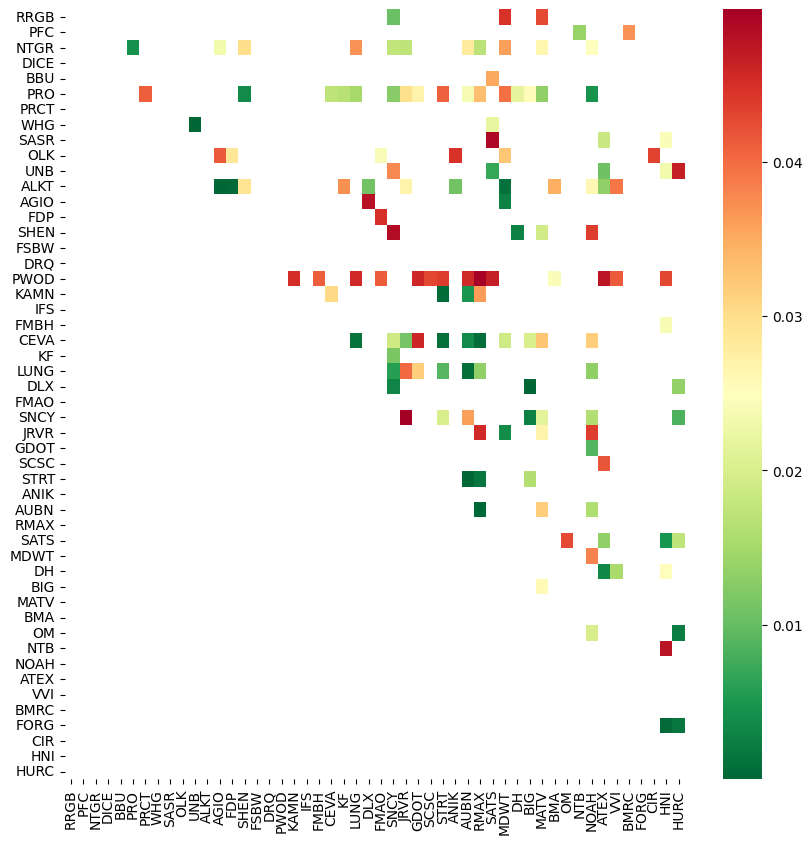

In [111]:
###val set heatmap###
#Remember to use the same cluster as train set
#valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF[good_clusters_dict[9]].loc[round(len(dailyDF)*0.7):].dropna(axis=1, how='all'))

valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF_train.loc[train_enddate:].dropna(axis=1, how='all'))

In [112]:
len(valpairs)

23

In [115]:
###create valenvs###
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()

In [582]:
len(valenvs)

23

In [586]:
len(valdf)

849

**DEEP Q-NETWORK**

**Hyperparameters to tune**
1. Larger memory: 64000 - no visible improvement
2. lr: 1e-2 (R&R = 0, not sensitve at all), 1e-6 (show improving trend but R&R still negative)
3. activation function at output layer: Softmax can get to +ve return but reward still -ve; Sigmoid: +ve R&R! Record high scores!
4. different loss function: MSELoss terrible; L1Loss not impressive; BCELoss record scores! but seems unstable
5. GAMMA, TARGET_UPDATE
6. [more layers]
7. [increase batch size]

In [732]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.02   #decreased from 0.05
#EPS_DECAY = 200
EPS_DECAY = 500
TARGET_UPDATE = 5

# Get number of actions from gym action space
#n_actions = 3
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

#optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam
#memory = ReplayMemory(10000)
memory = ReplayMemory(127000)

In [733]:
###training agent###
num_episodes = 300
best_rewards = 0
steps_done = 0

#empty dicts to collect train/test rewards/returns
train_reward_dict = {}
train_return_dict = {}
val_reward_dict = {}
val_return_dict = {}


for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []

    #initialize train_reward_dict and train_return_dict for this
    train_reward_dict[i_episode] = []
    train_return_dict[i_episode] = []
    val_reward_dict[i_episode] = []
    val_return_dict[i_episode] = []

    #initialize nn_counter for this episode
    nn_counter = 0
    
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        
        for t in count():   #keep looping until done -> break
            # Select and perform an action and return whether this action is returned by policy_network
            action, nn_count = DQN.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions, device)   #epsilon-greedy: exploit or explore; state is this state
            #obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            obs, step_reward, done, info, step_return = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            #append reward and return of this episode in the list
            train_reward_dict[i_episode].append(step_reward)
            train_return_dict[i_episode].append(step_return)
            
            step_reward = torch.tensor([step_reward], dtype=torch.float, device=device)
            step_return = torch.tensor([step_return], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 3 = 127 
            memory.push(state, action, next_state, step_reward)

            # Move to the next state
            state = next_state

            #tick steps_done to trigger epsilon-greedy
            steps_done += 1
            nn_counter += nn_count

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            DQN.optimize_model(memory, BATCH_SIZE, device, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, step_reward, done, info, step_return = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                #append reward and return of this episode in the list
                val_reward_dict[i_episode].append(step_reward)
                val_return_dict[i_episode].append(step_return)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}, policy_nn_actions:{:.4f}, training steps:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns), nn_counter, len(train_reward_dict[i_episode])))

print('Complete')

epoch [1/300], train rewards:-55.0854, returns:-18.5239, val rewards:-2.0315, returns:-0.0799, policy_nn_actions:30701.0000, training steps:31756.0000
epoch [2/300], train rewards:-58.0225, returns:-21.2750, val rewards:-0.5687, returns:0.6591, policy_nn_actions:31118.0000, training steps:31756.0000
epoch [3/300], train rewards:-47.4975, returns:-17.6429, val rewards:-0.1618, returns:0.6432, policy_nn_actions:31165.0000, training steps:31756.0000
epoch [4/300], train rewards:-30.5146, returns:-6.2652, val rewards:0.4779, returns:1.2491, policy_nn_actions:31104.0000, training steps:31756.0000
epoch [5/300], train rewards:-26.9248, returns:-7.1277, val rewards:0.6357, returns:1.3759, policy_nn_actions:31143.0000, training steps:31756.0000
epoch [6/300], train rewards:-26.1010, returns:-8.9955, val rewards:1.0207, returns:1.8410, policy_nn_actions:31124.0000, training steps:31756.0000
epoch [7/300], train rewards:-21.2050, returns:-5.9551, val rewards:2.6025, returns:3.2655, policy_nn_act

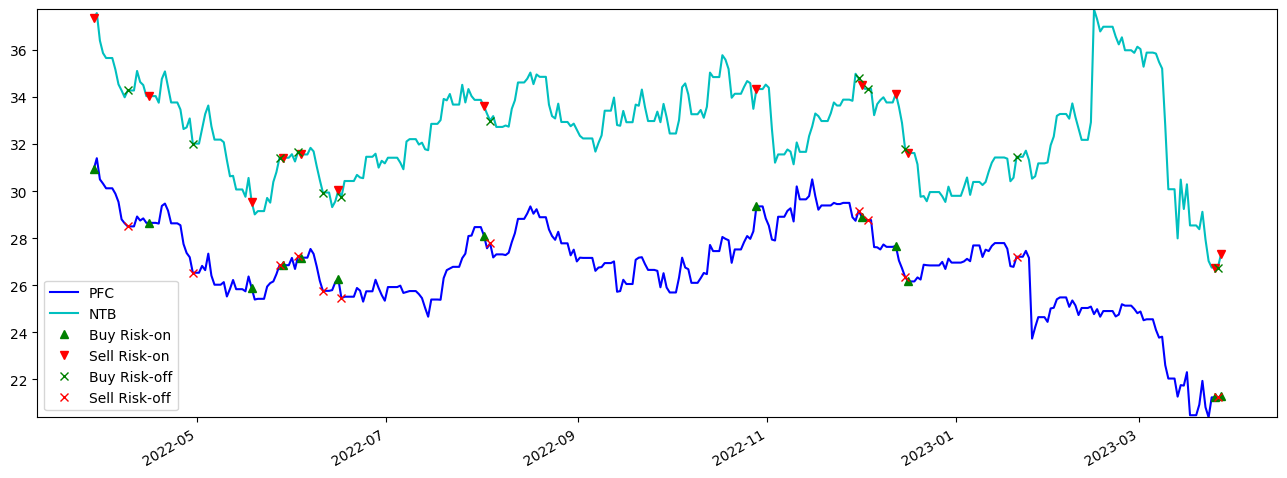

Total reward for this pair: -6.6623999043058655
Total return for this pair: -6.334294499484308


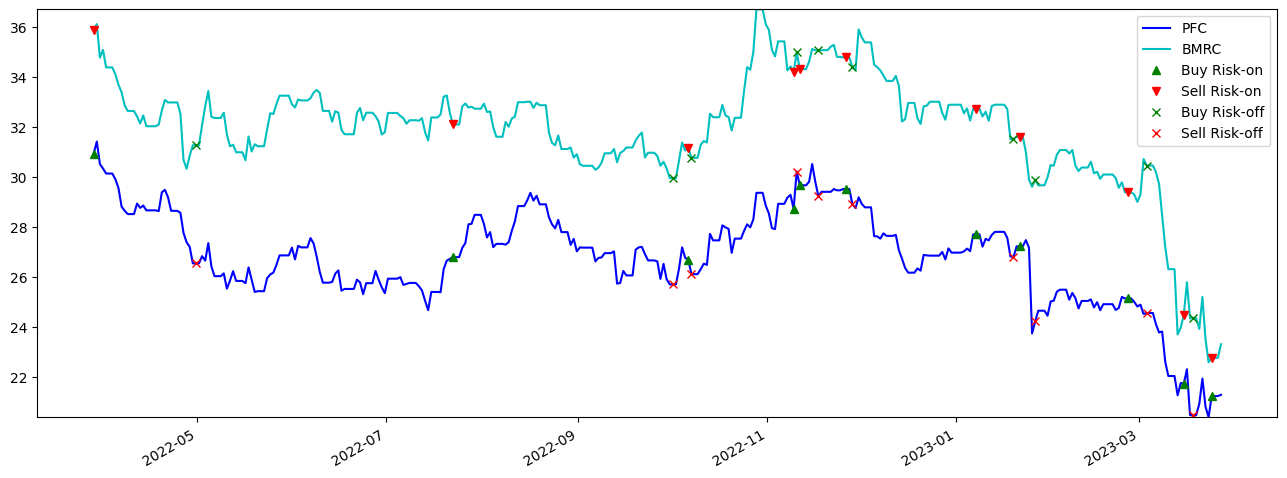

Total reward for this pair: -12.248813636899953
Total return for this pair: -11.611831495094993


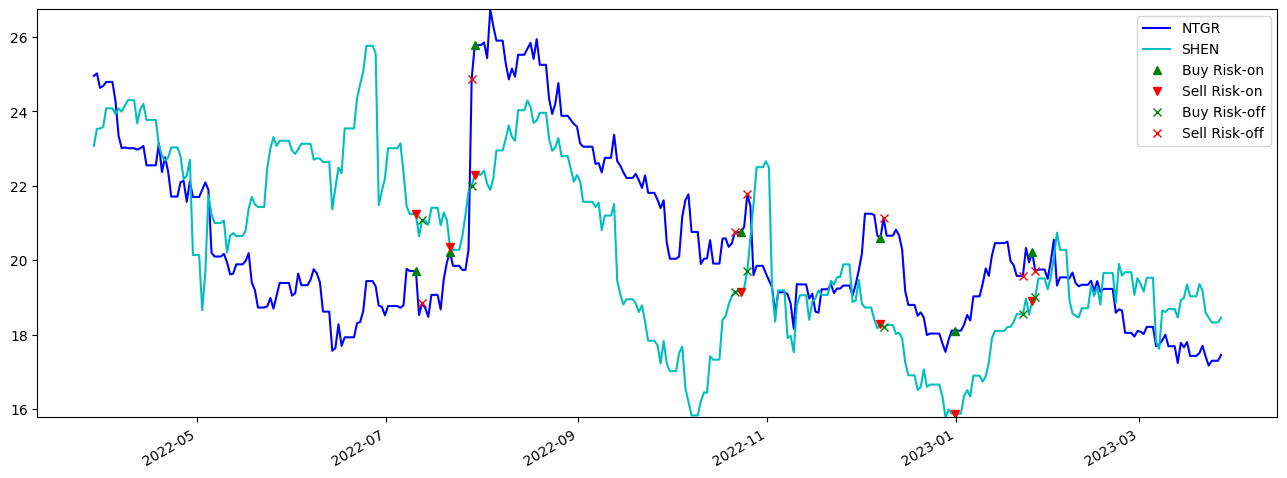

Total reward for this pair: -5.4654626106744155
Total return for this pair: -4.686078686757547


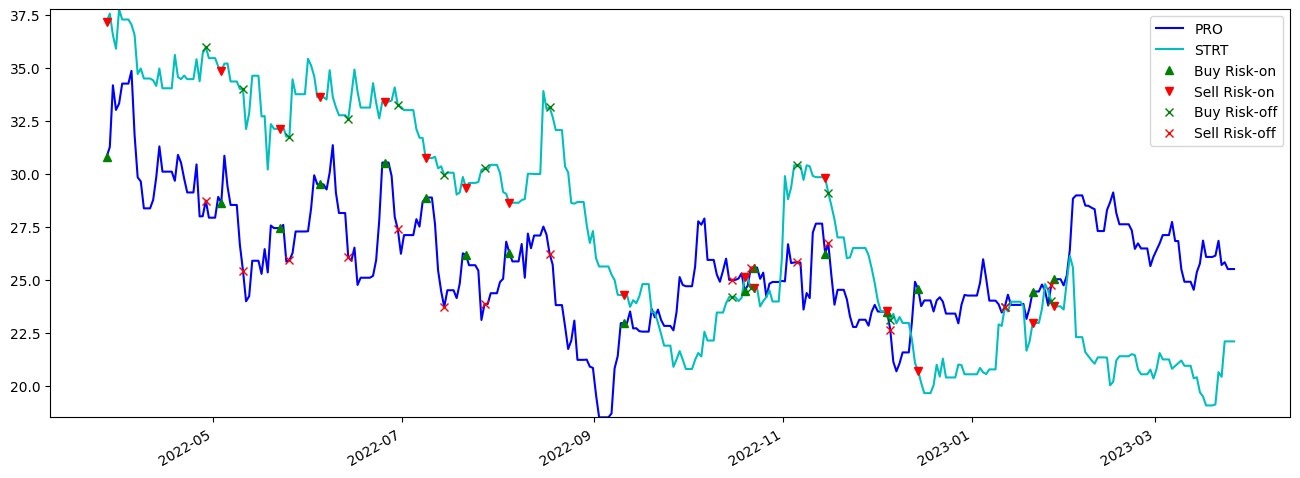

Total reward for this pair: -49.10716814864876
Total return for this pair: -47.94308905218267


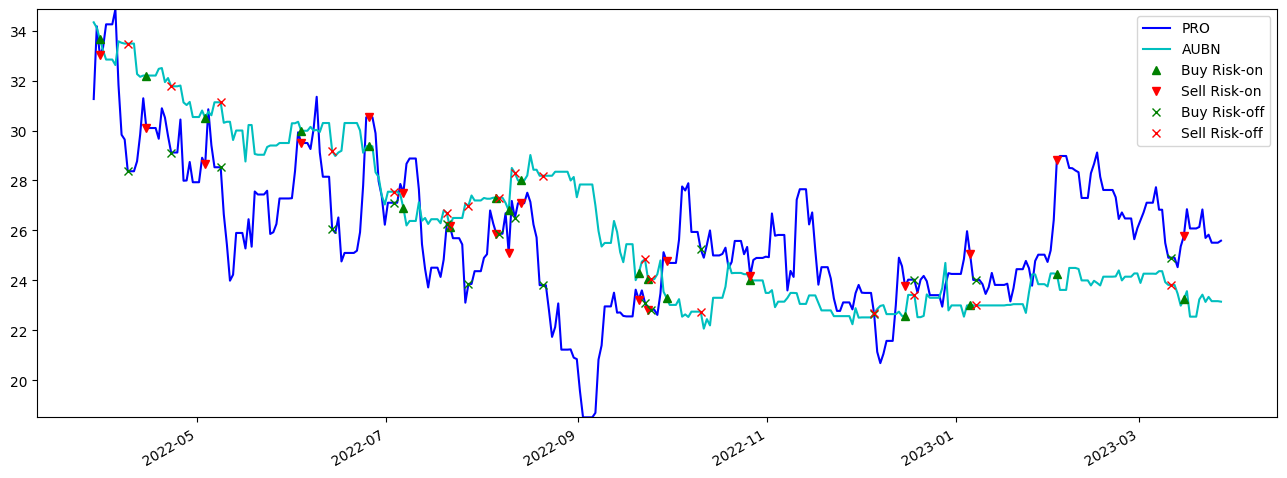

Total reward for this pair: 27.05283135572401
Total return for this pair: 28.694207957015145


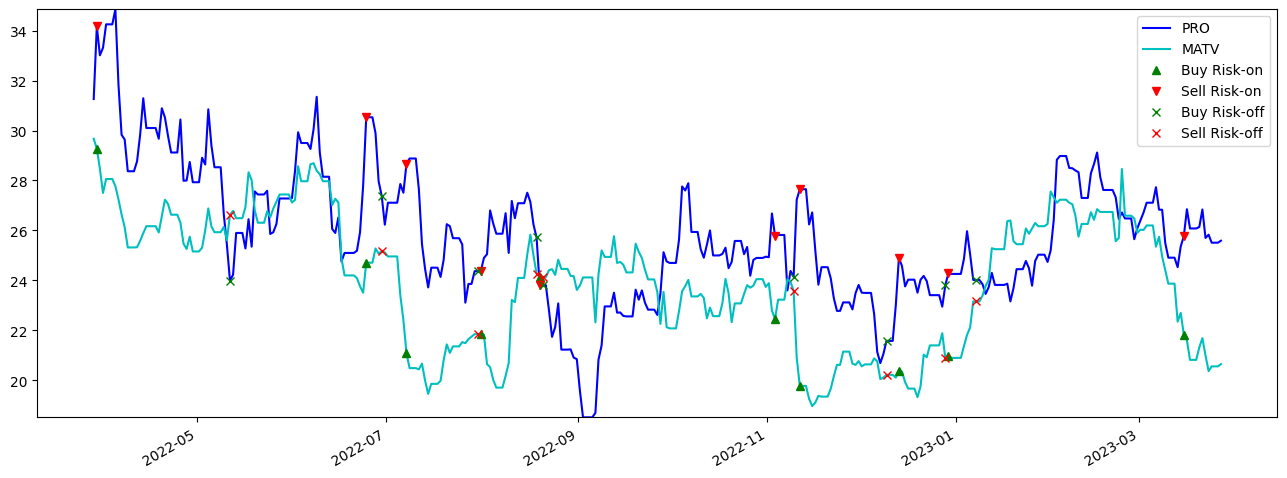

Total reward for this pair: 37.285915571791406
Total return for this pair: 39.13124557983415


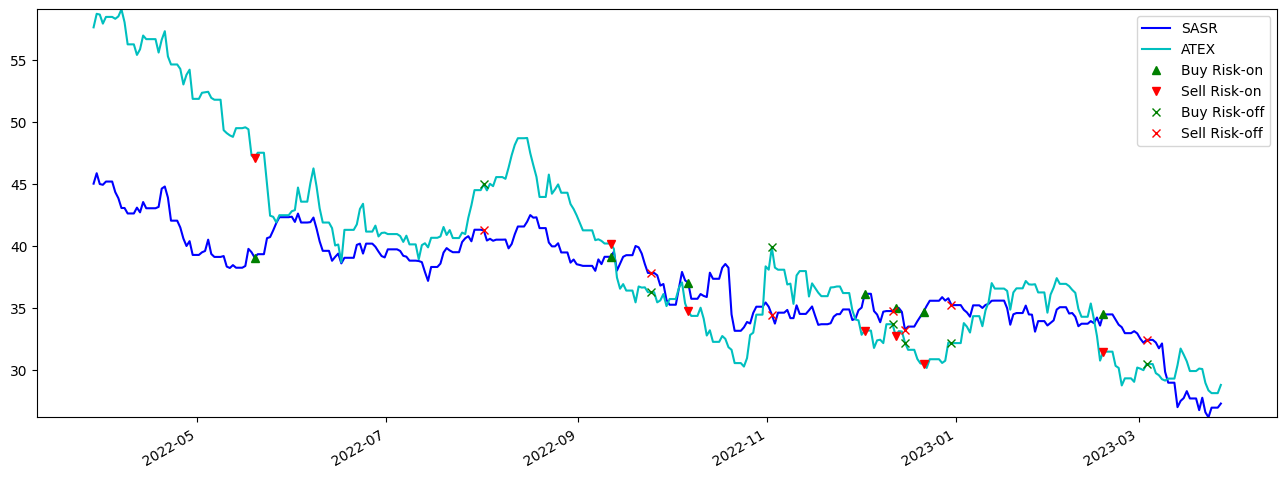

Total reward for this pair: -13.332575953335674
Total return for this pair: -12.821051761592056


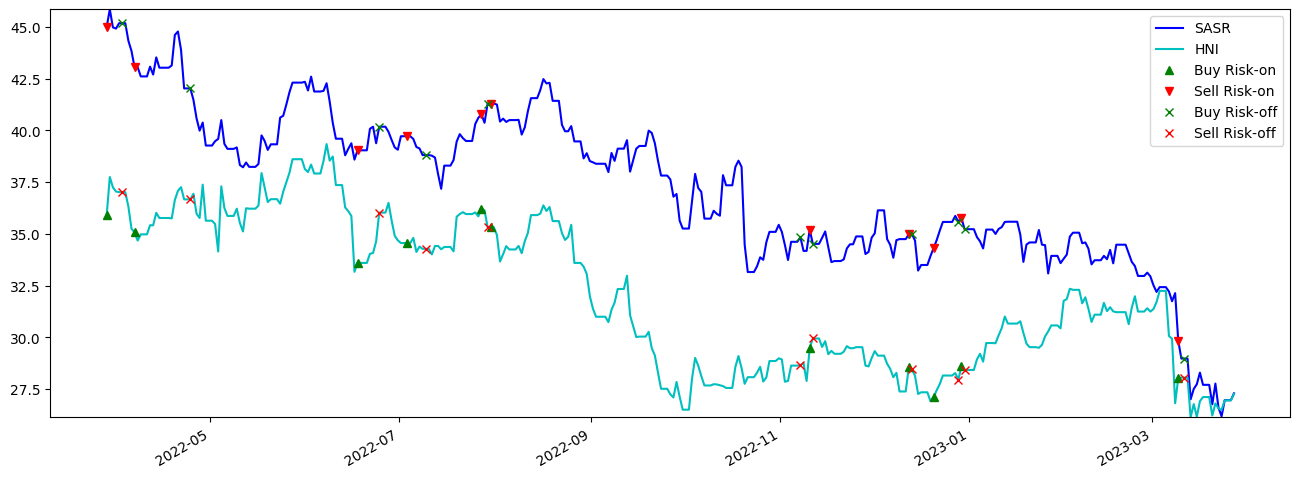

Total reward for this pair: 6.497307305843169
Total return for this pair: 7.249261501666653


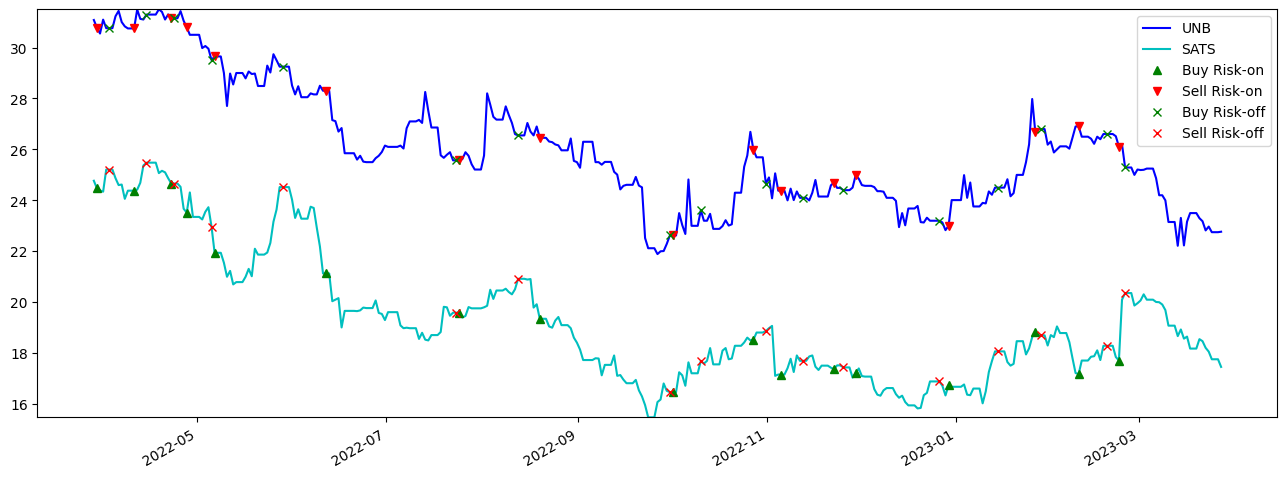

Total reward for this pair: 24.08976781012219
Total return for this pair: 25.083235732165367


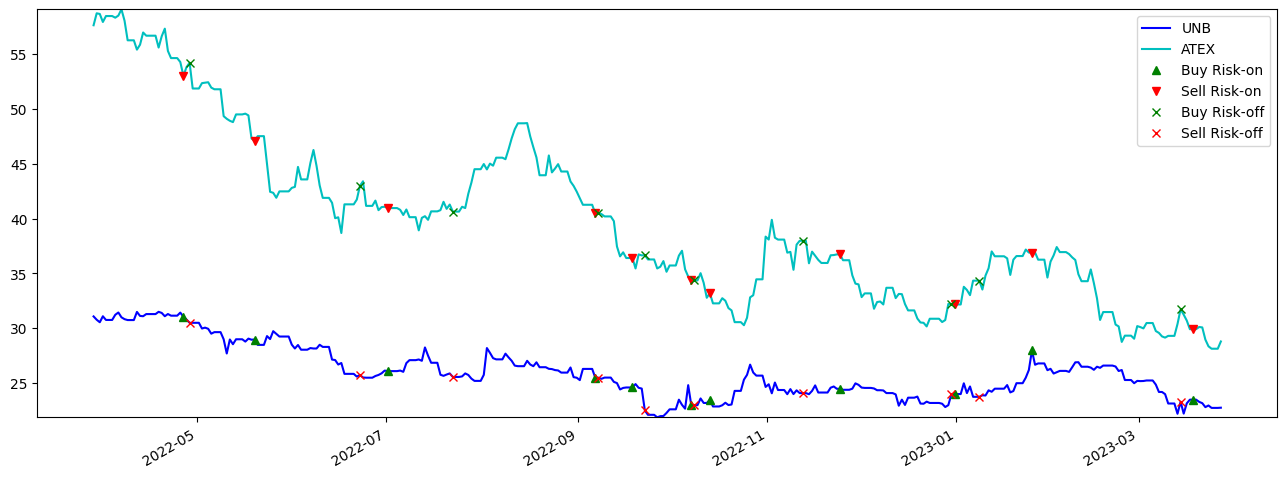

Total reward for this pair: -16.09657416396243
Total return for this pair: -15.473364630345774


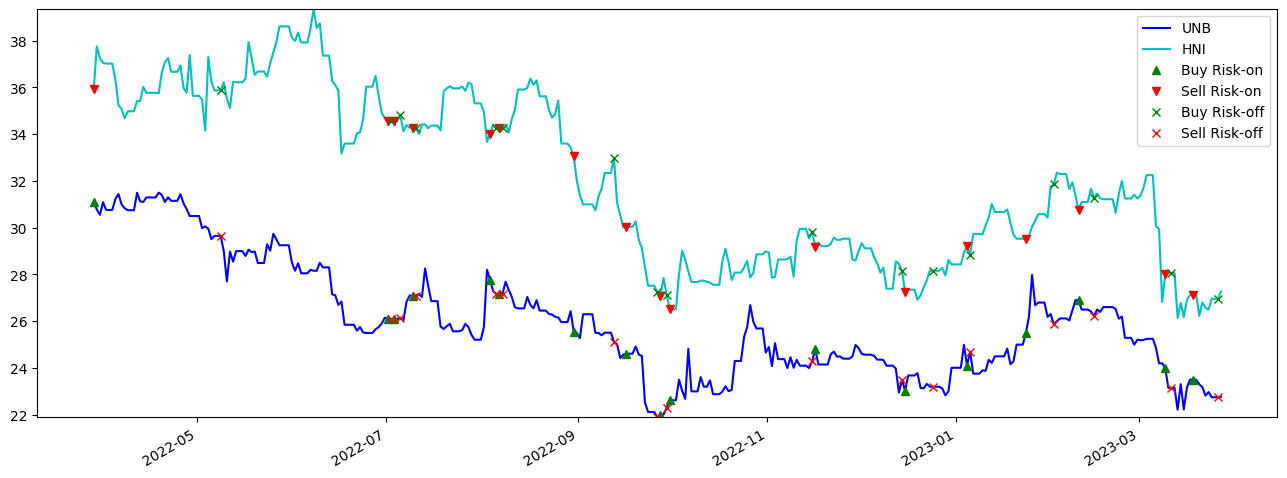

Total reward for this pair: -10.285747314867042
Total return for this pair: -9.42478237750511


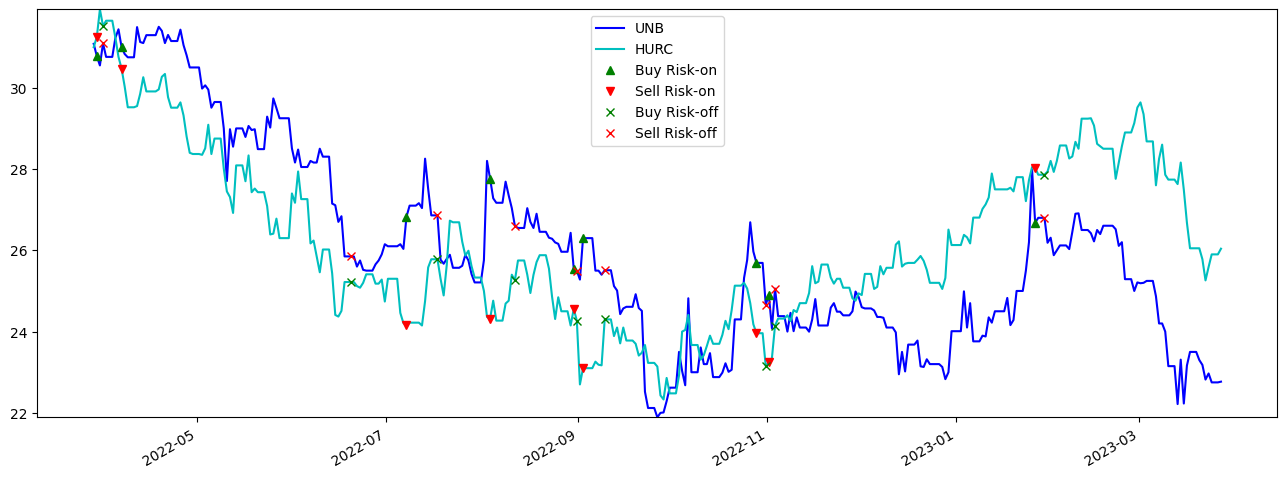

Total reward for this pair: -12.105935802827444
Total return for this pair: -11.68887809538851


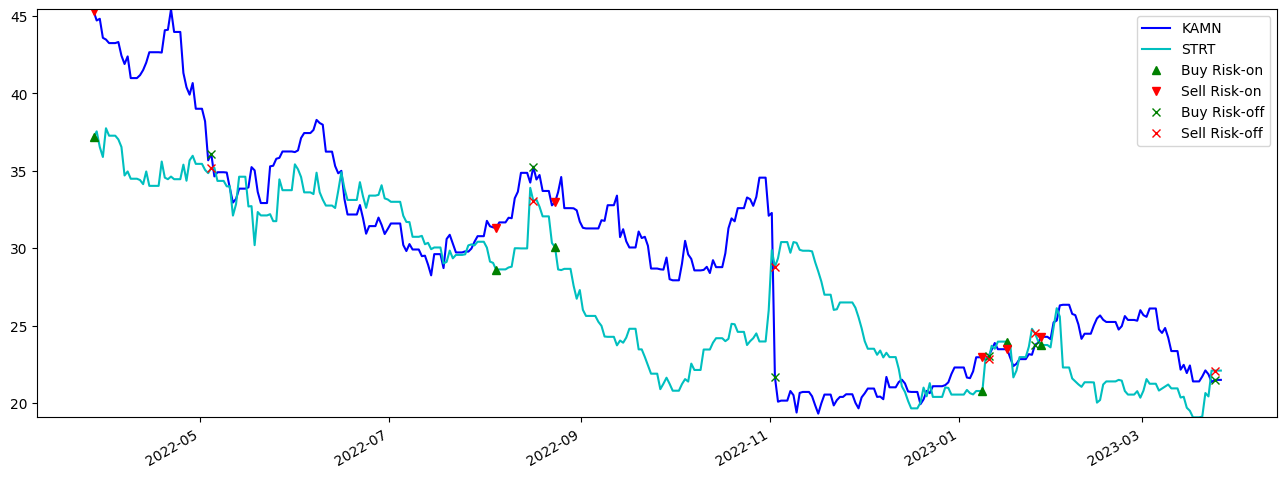

Total reward for this pair: 30.27252842483192
Total return for this pair: 31.07022868522104


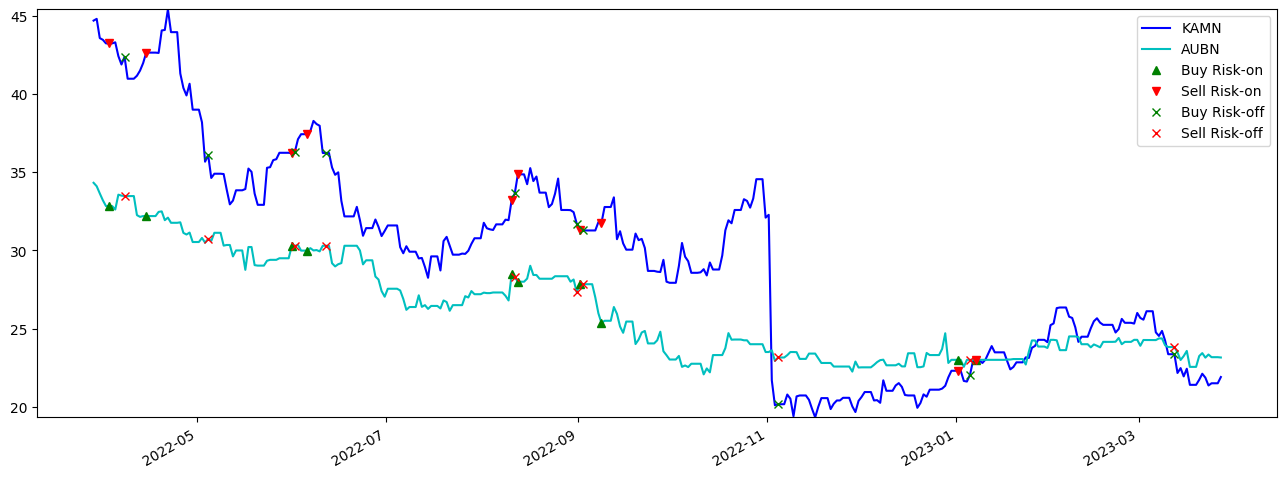

Total reward for this pair: 19.988863301134046
Total return for this pair: 21.432615879007876


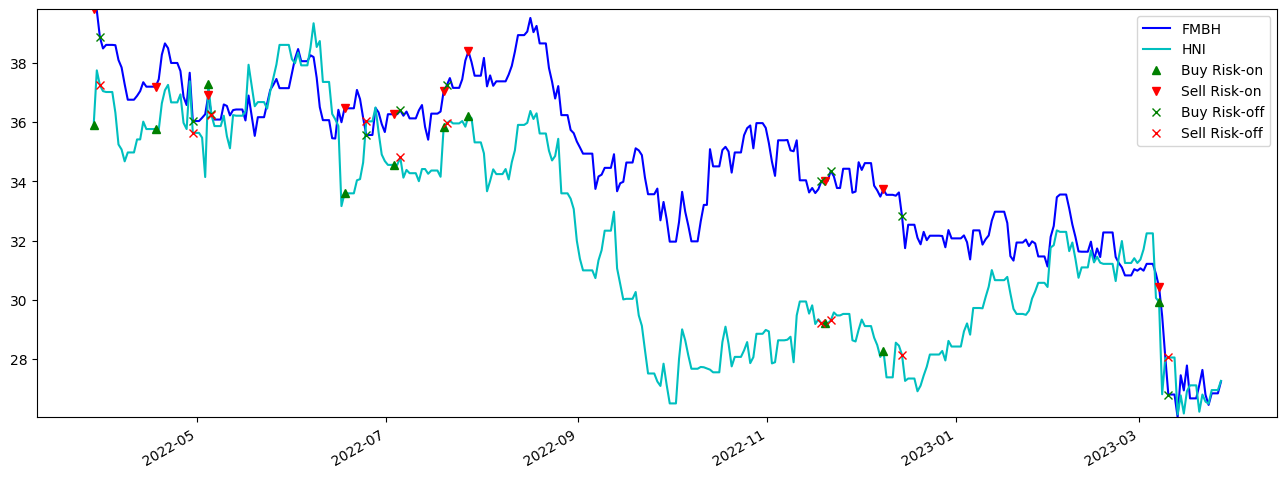

Total reward for this pair: 2.501231314400551
Total return for this pair: 3.5625658353301546


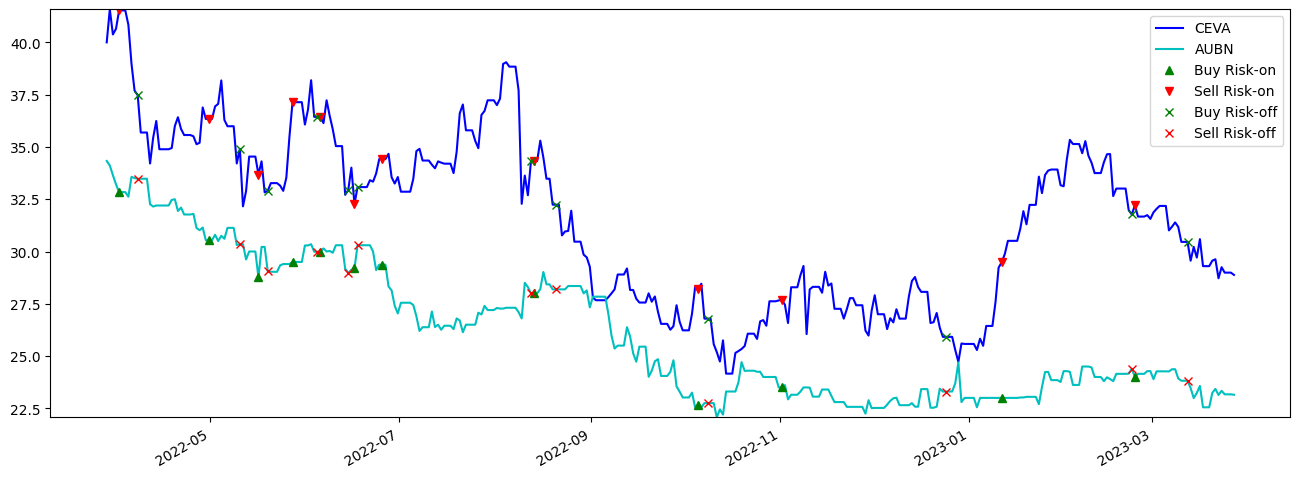

Total reward for this pair: 30.31721477157074
Total return for this pair: 31.61700001811006


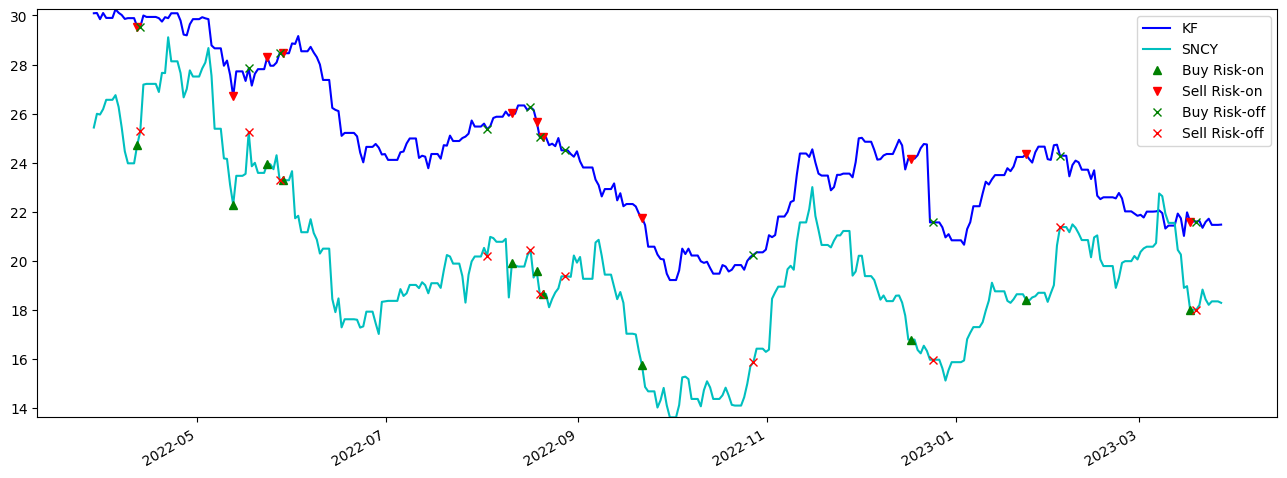

Total reward for this pair: 21.33475287252592
Total return for this pair: 22.038366461259567


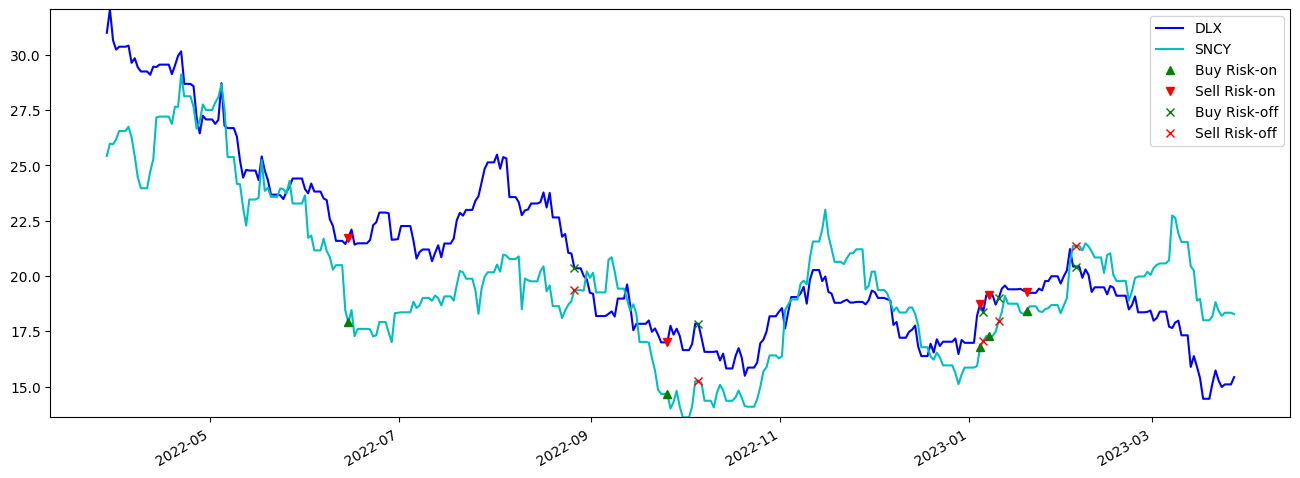

Total reward for this pair: 27.607917851032283
Total return for this pair: 28.237589703802648


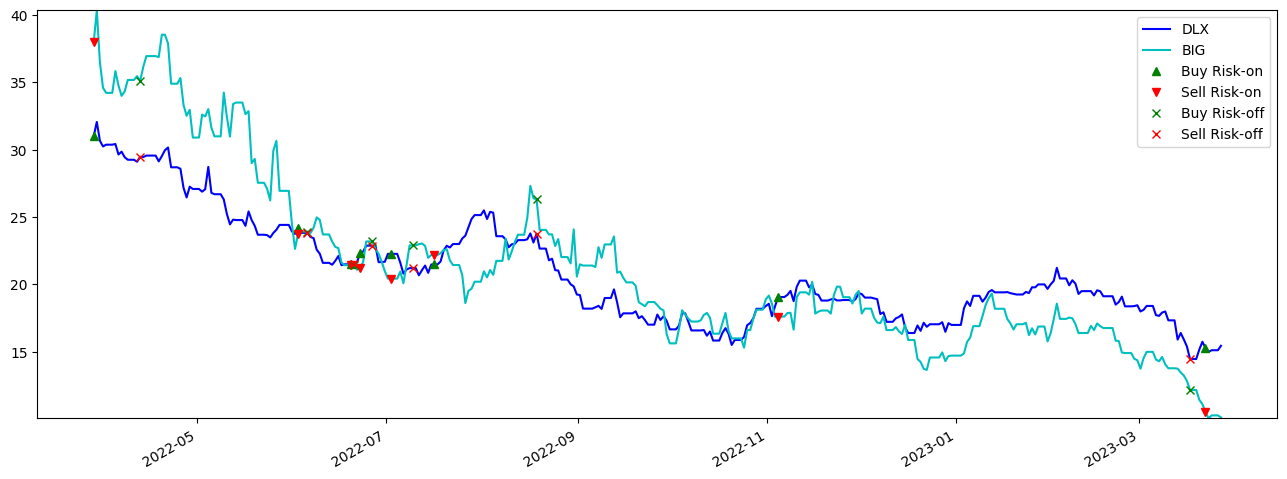

Total reward for this pair: -7.386374325061534
Total return for this pair: -7.0205808152461024


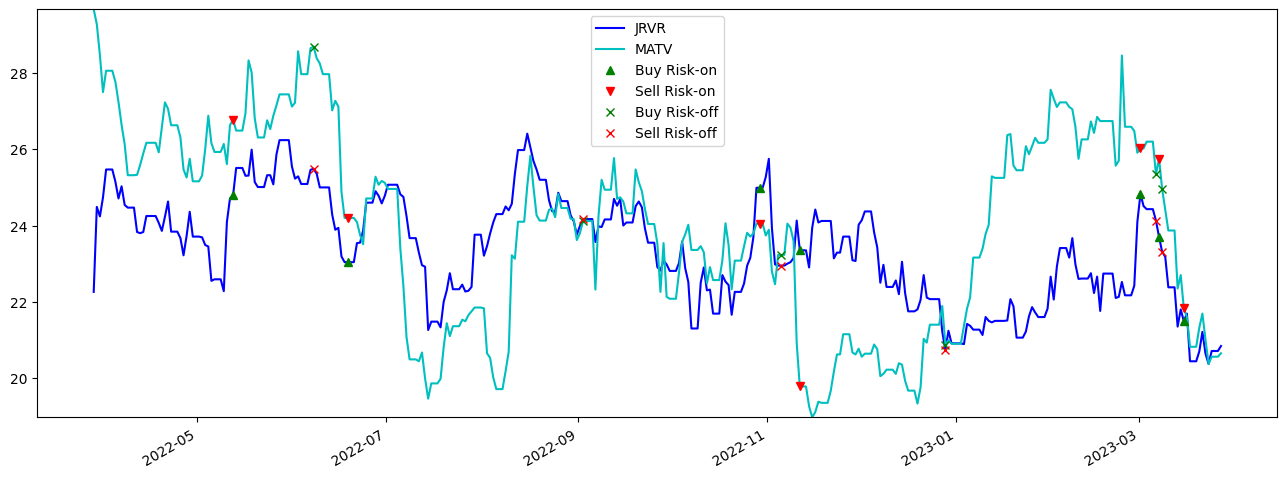

Total reward for this pair: -17.1960341034418
Total return for this pair: -16.595438128616756


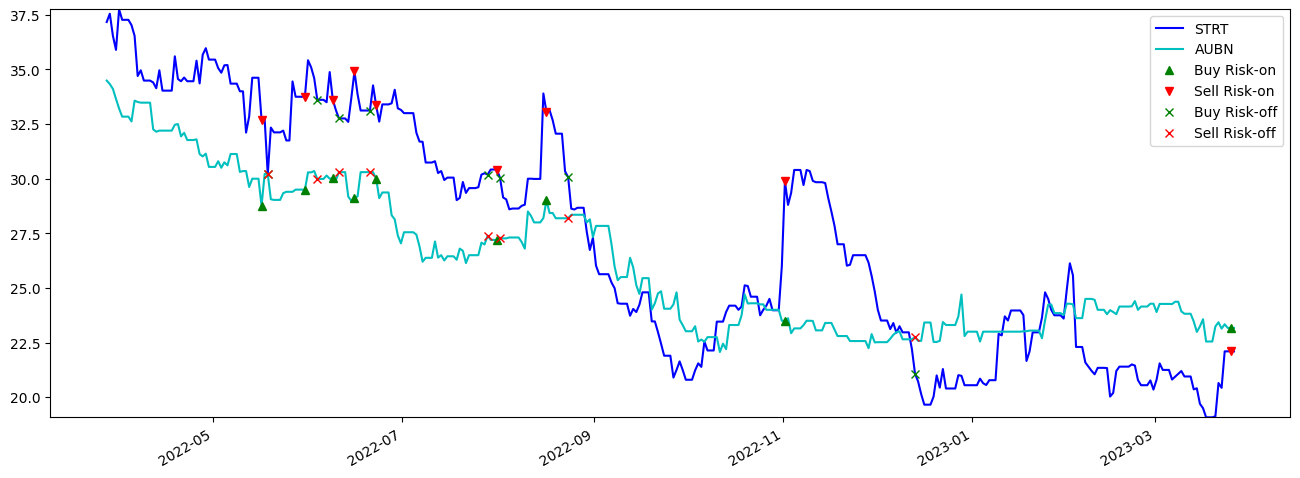

Total reward for this pair: 29.999696189958534
Total return for this pair: 31.661014497107267


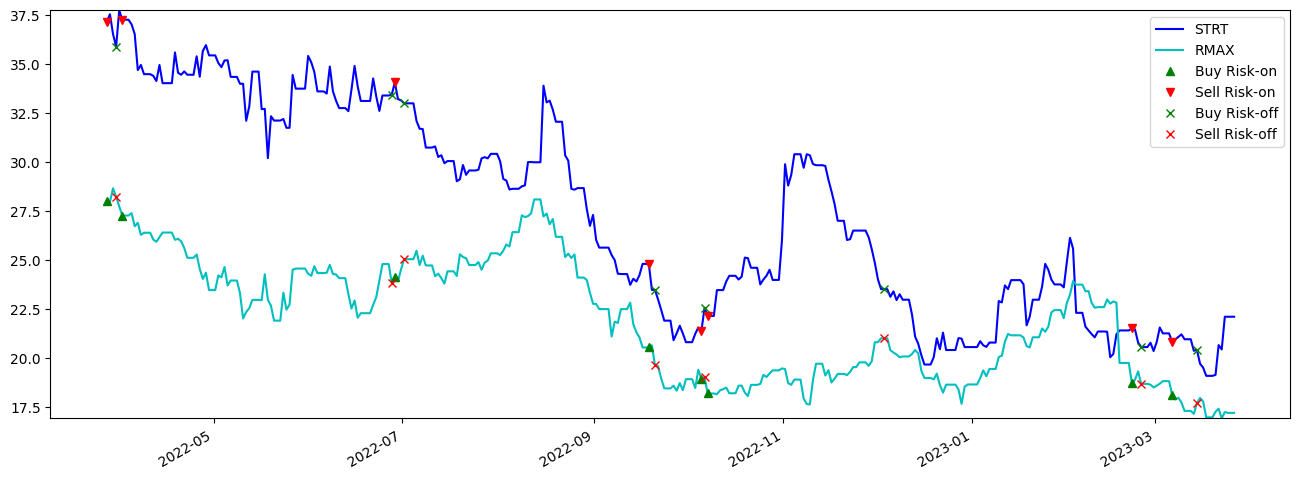

Total reward for this pair: 31.288267026282043
Total return for this pair: 32.78744909928898


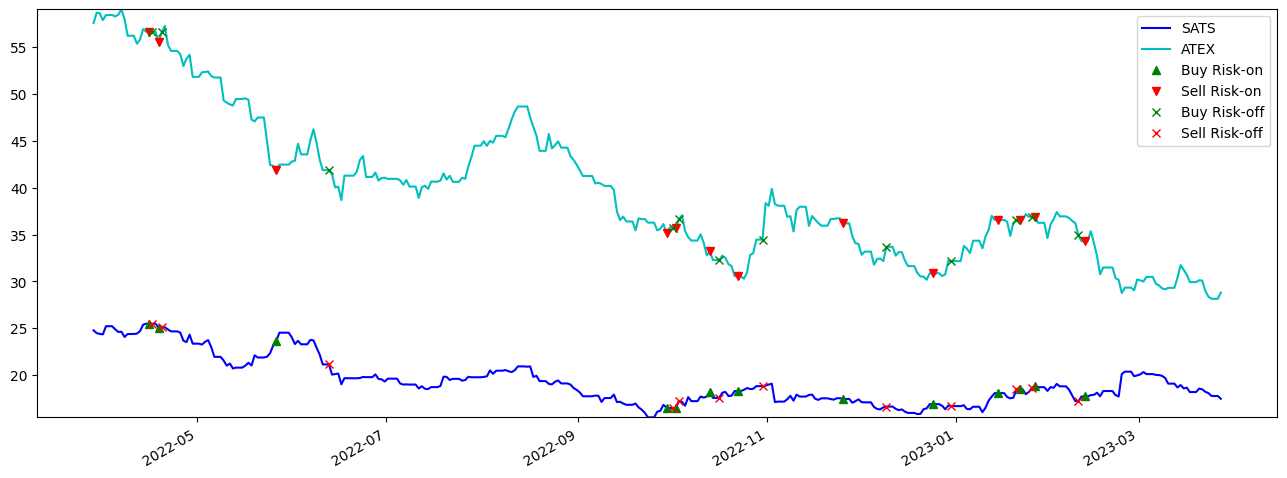

Total reward for this pair: -20.658438813001084
Total return for this pair: -19.98245334106388
Average overall rewards: 5.1169899573126445
Average overall returns: 6.04273643767527


In [734]:
###plot###
#fill in latest/best model
policy_net.load_state_dict(torch.load('./models/model (64).pth'))
#policy_net.load_state_dict(torch.load('./models/model (63)_300eps.pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

total_rewards = []
total_returns = []
with torch.no_grad():
    for valenv in valenvs:
        obs = valenv.reset()
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, _reward, done, info, _return = valenv.step(Positions(action.item()))
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            
            if done:
                valenv.render()   #only rendering the last year
                #total_returns.append(returns)   ###changed###
                #total_returns.append(np.sum(returns))   ###changed###
                print(f"Total reward for this pair: {info['total_reward']}")
                print(f"Total return for this pair: {info['total_return']}")
                total_rewards.append(info['total_reward'])
                total_returns.append(info['total_return'])
                break

#avg_returns = np.mean(returns)
print(f'Average overall rewards: {np.mean(total_rewards)}')
print(f'Average overall returns: {np.mean(total_returns)}')

plt.ioff()
plt.show()

In [765]:
steps_done

9526800

In [735]:
val_return_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [736]:
len(val_reward_dict[4])

16505

In [760]:
def plot_episodes(data_dict):
    # Convert dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='columns').astype(float)

    #Plot all reward/return across all the paths and episodes
    sns.lineplot(data=df, dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendlines showing trends')
    plt.xlabel('Steps in each episode')
    plt.show()


    # Calculate the (means) cumsum for each column
    #means = df.mean()
    cumsum = df.cumsum()
    
    # get the index of the column with the highest cumulative sum
    highest_cumulative_sum = cumsum.sum().idxmax()

    #print("Column with highest cumulative sum:", highest_cumulative_sum)

    #Plot all cumulative sums
    sns.lineplot(data=cumsum, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing change in cumulative returns across episodes')
    plt.xlabel('Steps in each episode')
    plt.ylabel('Cumulative return')
    plt.show()


    #Plot the highest cumulative sum only
    sns.lineplot(data=cumsum[highest_cumulative_sum], legend=False)#, palette=['pink'], dashes=False, legend=False)

    # Set the plot title and axis labels
    plt.suptitle('Trendline showing cumulative returns in the highest-return episode')
    plt.xlabel('Steps in the episode')
    plt.ylabel('Cumulative return')

    # Display the plot
    plt.show()
    print(f'Highest cumulative return in epoch {highest_cumulative_sum}, return: {cumsum.iloc[-1][highest_cumulative_sum]}')

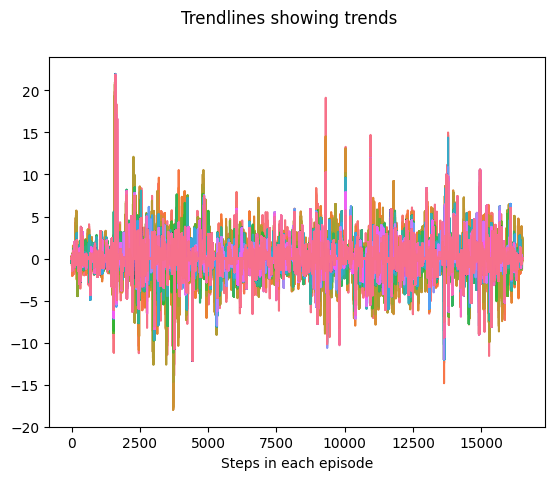

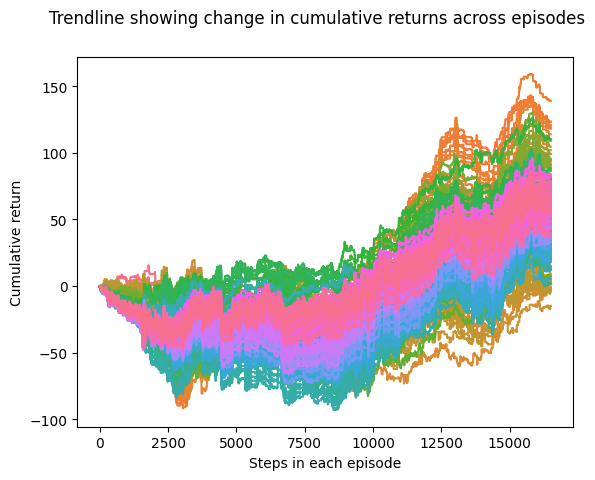

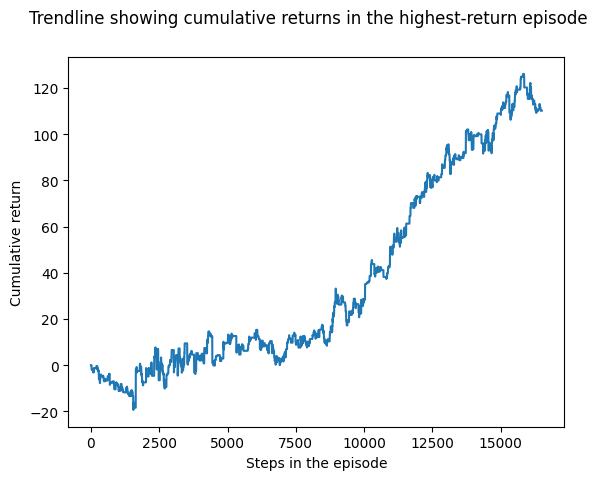

Highest cumulative return in epoch 105, return: 110.17292835295139


In [761]:
plot_episodes(val_return_dict)

In [763]:
def get_episodes(data_dict):
    # Convert dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='columns').astype(float)

    # Calculate the (means) cumsum for each column
    #means = df.mean()
    cumsum = df.iloc[:,200:].cumsum()

    #Plot all cumulative sums
    sns.lineplot(data=cumsum, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing change in cumulative returns across episodes')
    plt.xlabel('Steps in each episode')
    plt.ylabel('Cumulative return')
    plt.show()

    
    # get the index of the column with the highest cumulative sum
    highest_cumulative_sum = cumsum.sum().idxmax()

    #print("Column with highest cumulative sum:", highest_cumulative_sum)
    print(f'Highest cumulative return in epoch {highest_cumulative_sum}, return: {cumsum.iloc[-1][highest_cumulative_sum]}.')

    return cumsum

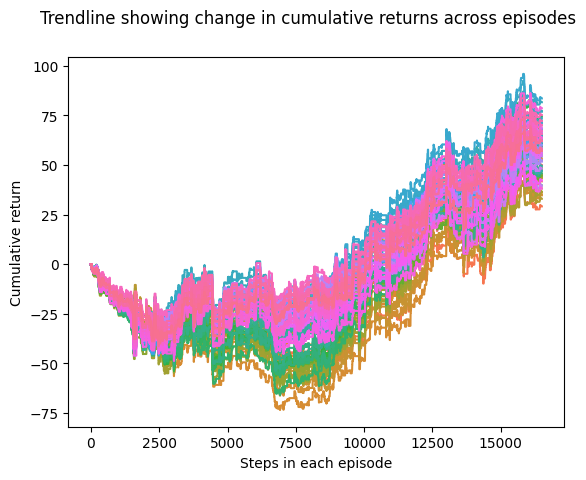

Highest cumulative return in epoch 262, return: 83.55241387086352.


200        201       202        203        204       205  \
0       0.000000   0.000000   0.00000   0.000000   0.000000   0.00000   
1       0.000000   0.000000   0.00000   0.000000   0.000000   0.00000   
2       0.000000   0.000000   0.00000   0.000000   0.000000   0.00000   
3       0.000000   0.000000   0.00000   0.000000   0.000000   0.00000   
4       0.000000   0.000000   0.00000   0.000000   0.000000   0.00000   
...          ...        ...       ...        ...        ...       ...   
16500  45.387012  49.966063  59.02046  48.073438  41.717455  29.10458   
16501  45.387012  49.966063  59.02046  48.073438  41.717455  29.10458   
16502  45.387012  49.966063  59.02046  48.073438  41.717455  29.10458   
16503  45.387012  49.966063  59.02046  48.073438  41.717455  29.10458   
16504  45.387012  49.966063  59.02046  48.073438  41.717455  29.10458   

             206        207       208        209  ...        290        291  \
0       0.000000   0.000000   0.00000   0.000000  ...   0.000000   0.000000   
1       0.000000   0.000000   0.00000   0.000000  ...   0.000000   0.000000   
2       0.000000   0.000000   0.00000   0.000000  ...   0.000000   0.000000   
3       0.000000   0.000000   0.00000   0.000000  ...   0.000000   0.000000   
4       0.000000   0.000000   0.00000   0.000000  ...   0.000000   0.000000   
...          ...        ...       ...        ...  ...        ...        ...   
16500  53.120668  54.442762  58.40373  64.478829  ...  67.158465  69.976267   
16501  53.120668  54.442762  58.40373  64.478829  ...  67.158465  69.976267   
16502  53.120668  54.442762  58.40373  64.478829  ...  67.158465  69.976267   
16503  53.120668  54.442762  58.40373  64.478829  ...  67.158465  69.976267   
16504  53.120668  54.442762  58.40373  64.478829  ...  67.158465  69.976267   

             292        293        294        295        296        297  \
0       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
...          ...        ...        ...        ...        ...        ...   
16500  66.936803  65.633009  75.205009  72.149377  62.264722  58.159235   
16501  66.936803  65.633009  75.205009  72.149377  62.264722  58.159235   
16502  66.936803  65.633009  75.205009  72.149377  62.264722  58.159235   
16503  66.936803  65.633009  75.205009  72.149377  62.264722  58.159235   
16504  66.936803  65.633009  75.205009  72.149377  62.264722  58.159235   

             298        299  
0       0.000000   0.000000  
1       0.000000   0.000000  
2       0.000000   0.000000  
3       0.000000   0.000000  
4       0.000000   0.000000  
...          ...        ...  
16500  61.951987  57.058508  
16501  61.951987  57.058508  
16502  61.951987  57.058508  
16503  61.951987  57.058508  
16504  61.951987  57.058508  

[16505 rows x 100 columns]

In [764]:
get_episodes(val_return_dict)

# Truly unseen data #

In [767]:
#revisit how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 59 stocks
cluster 1: 344 stocks
cluster 3: 80 stocks
cluster 4: 222 stocks
cluster 6: 14 stocks
cluster 7: 352 stocks
cluster 9: 18 stocks


In [787]:
#overall performance function###
def get_overall_performance(policy_net, target_net, testenvs):
    policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
    target_net.eval()

    total_rewards = []
    total_returns = []
    with torch.no_grad():
        for testenv in testenvs:
            obs = testenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info, _return = testenv.step(Positions(action.item()))
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
                
                if done:
                    #testenv.render()   #only rendering the last year
                    #print(f"Total reward for this pair: {info['total_reward']}")
                    #print(f"Total return for this pair: {info['total_return']}")
                    total_rewards.append(info['total_reward'])
                    total_returns.append(info['total_return'])
                    break

    #avg_returns = np.mean(returns)
    #print(f'Average overall rewards: {np.mean(total_rewards)}')
    #print(f'Average overall returns: {np.mean(total_returns)}')

    cluster_rewards = np.mean(total_rewards)
    cluster_returns = np.mean(total_returns)
    #plt.ioff()
    #plt.show()

    return cluster_rewards, cluster_returns

In [799]:
#find overall performance on all selected clusters, including unseen clusters
def unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    overall_rewards = []
    overall_returns = []

    for i in good_clusters_dict.keys():
        #choose cluster of a reasonable size as test cluster
        dailyDF_test = dailyDF[good_clusters_dict[i]]

        #no need to plot heatmap; just to get the testpairs, testpval, testdf,
        testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))
        print(f'Cluster {i} has {len(testpairs)} testpairs.')

        ###create testenvs###
        testenvs = []
        for testpair in testpairs:
            testdata = testdf[list(testpair)].dropna()
            if testdata.shape[0] > 250:
                #instantiate an env; automatatically run trade()
                testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, trade_period, transaction_cost))

        #get overall performance
        cluster_rewards, cluster_returns = get_overall_performance(policy_net, target_net, testenvs)
        print(f'For cluster {i}, overall reward is {cluster_rewards}, overall return is {cluster_returns}')

        overall_rewards.append(cluster_rewards)
        overall_returns.append(cluster_returns)
    
    print(f'For all clusters, total reward is {np.sum(overall_rewards)}, total return is {np.sum(overall_returns)}.')
    print(f'Average reward is {np.mean(overall_rewards)}, average return is {np.mean(overall_returns)}.')
        

In [801]:
unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)

Cluster 0 has 19 testpairs.
For cluster 0, overall reward is -5.869578365495114, overall return is -4.603282268839735
Cluster 1 has 163 testpairs.
For cluster 1, overall reward is -0.9855450391389057, overall return is -0.8072157544772255
Cluster 3 has 19 testpairs.
For cluster 3, overall reward is -6.320843247872126, overall return is -5.507787599792845
Cluster 4 has 8 testpairs.
For cluster 4, overall reward is 16.642946781980708, overall return is 17.58173363218567
Cluster 6 has 13 testpairs.
For cluster 6, overall reward is -7.026975286564223, overall return is -6.740261816191619
Cluster 7 has 20 testpairs.
For cluster 7, overall reward is -4.960778307431225, overall return is -4.714156618180428
Cluster 9 has 11 testpairs.
For cluster 9, overall reward is 20.79518094916561, overall return is 22.51895187969417
For all clusters, total reward is 12.274407484644723, total return is 17.72798145439799.
Average reward is 1.7534867835206747, average return is 2.532568779199713.


In [773]:
###plot function###
def plot_function(policy_net, target_net, testenvs):
    policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
    target_net.eval()

    total_rewards = []
    total_returns = []
    with torch.no_grad():
        for testenv in testenvs:
            obs = testenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info, _return = testenv.step(Positions(action.item()))
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
                
                if done:
                    testenv.render()   #only rendering the last year
                    print(f"Total reward for this pair: {info['total_reward']}")
                    print(f"Total return for this pair: {info['total_return']}")
                    total_rewards.append(info['total_reward'])
                    total_returns.append(info['total_return'])
                    break

    #avg_returns = np.mean(returns)
    print(f'Average overall rewards: {np.mean(total_rewards)}')
    print(f'Average overall returns: {np.mean(total_returns)}')

    plt.ioff()
    plt.show()

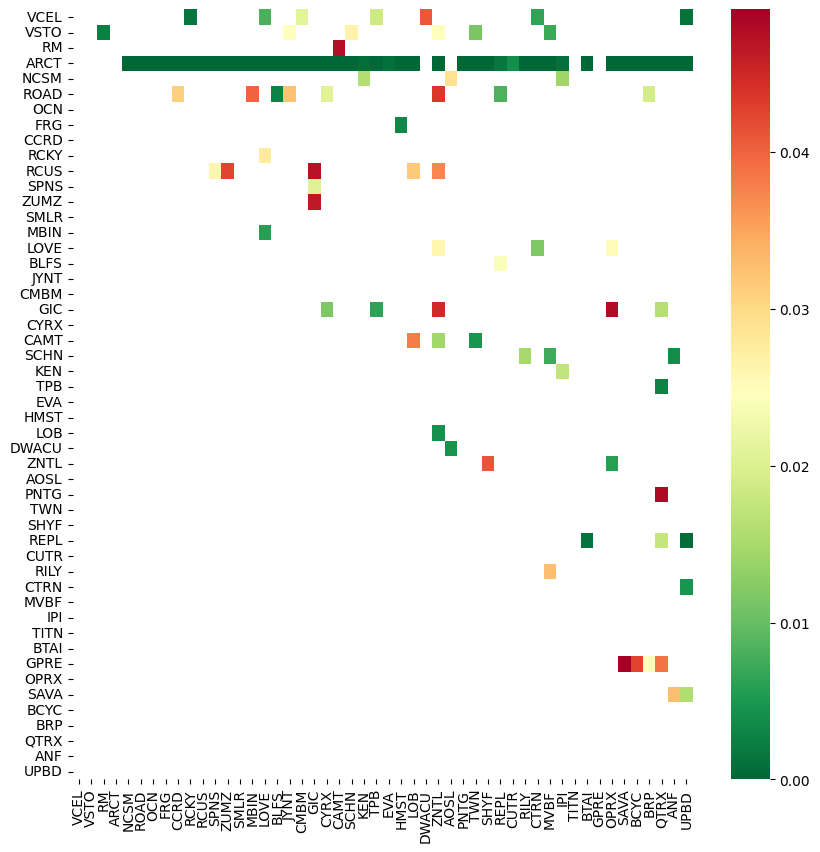

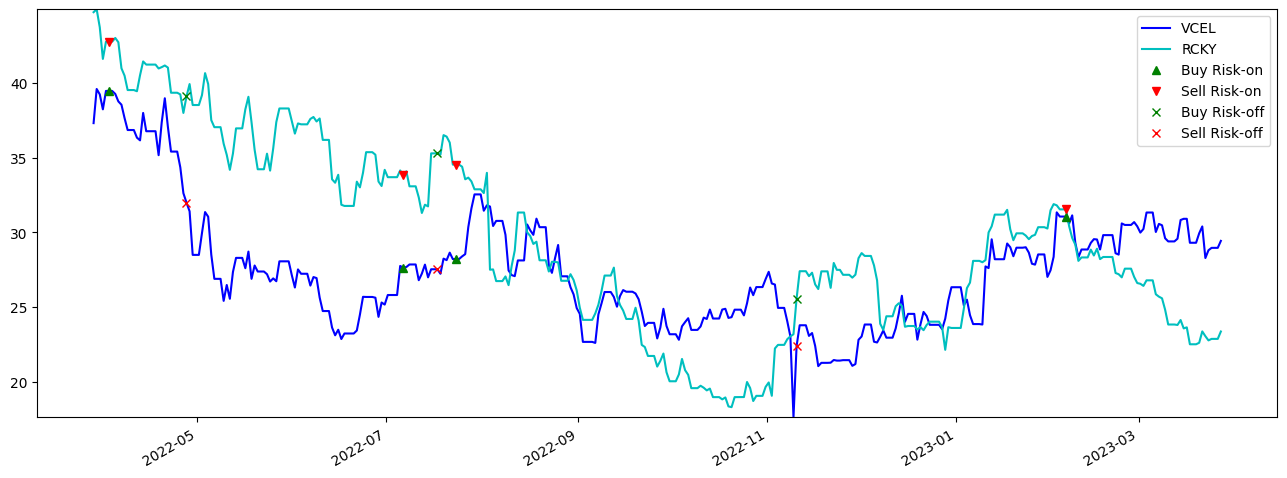

Total reward for this pair: -44.329900013916635
Total return for this pair: -42.89890700600064


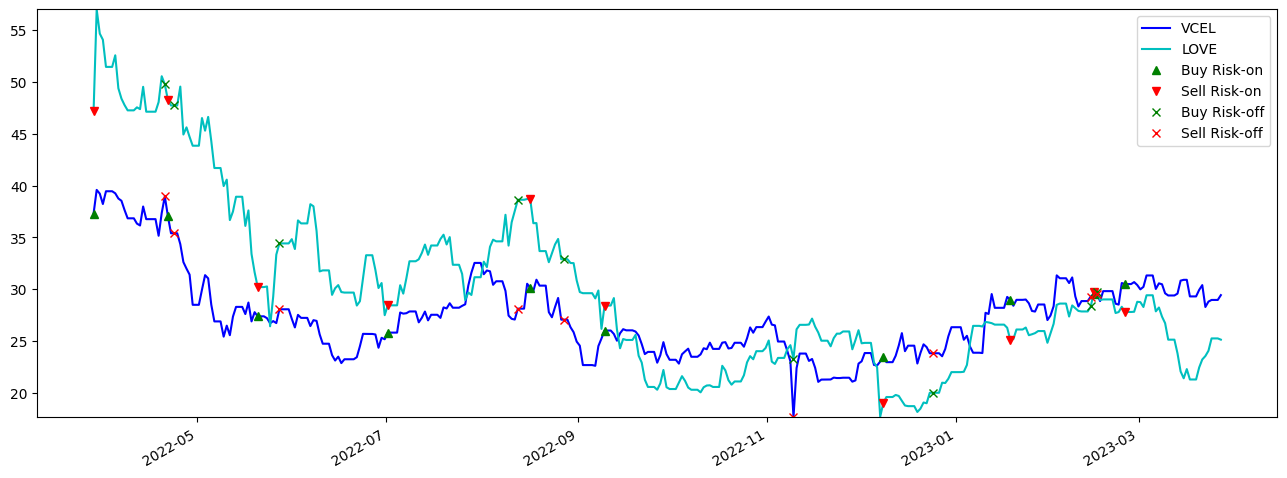

Total reward for this pair: -33.91960507508326
Total return for this pair: -32.19312421914565


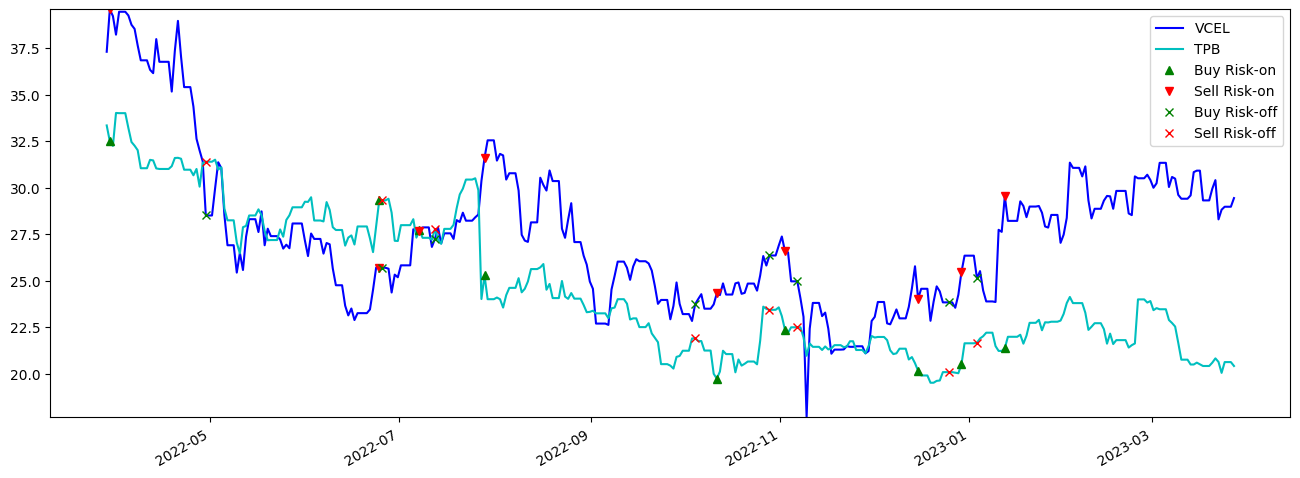

Total reward for this pair: 42.432070522753996
Total return for this pair: 43.86755319969819


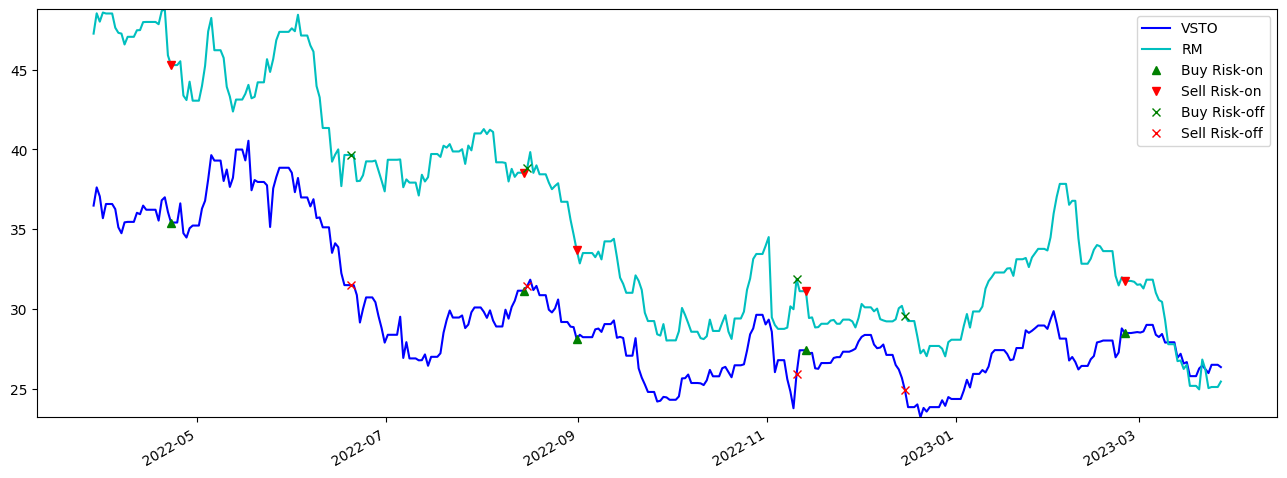

Total reward for this pair: -19.360622156956182
Total return for this pair: -18.931036450990558


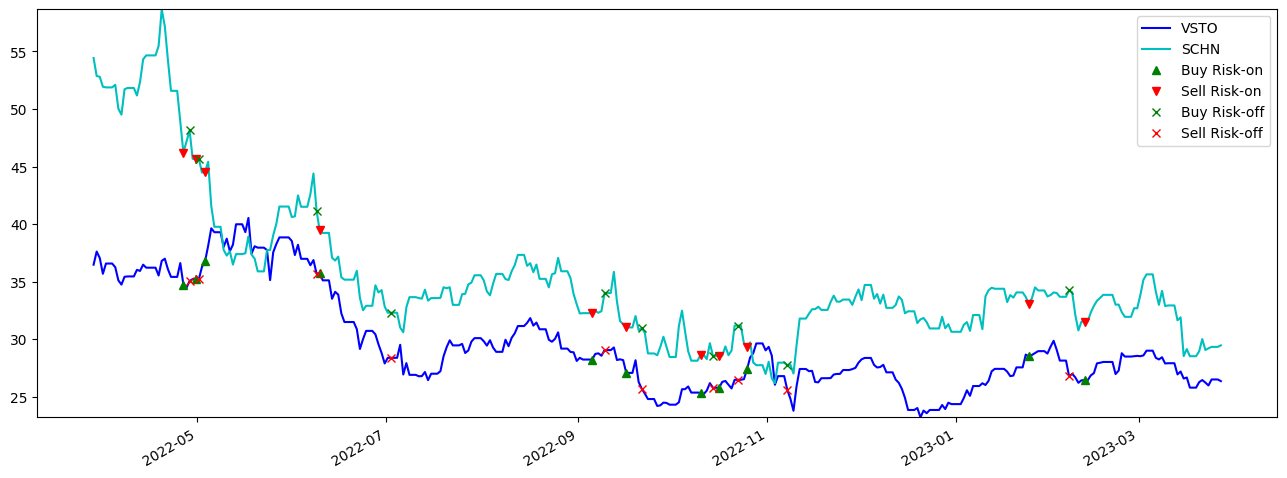

Total reward for this pair: -24.795419606524415
Total return for this pair: -23.70508442466927


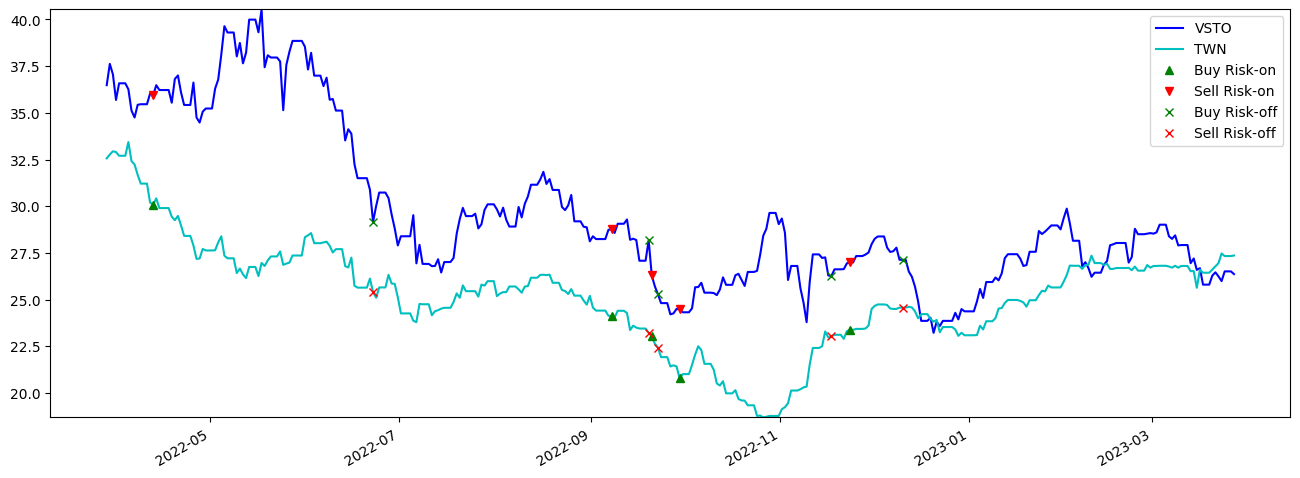

Total reward for this pair: 18.76927569348458
Total return for this pair: 19.721773056112223


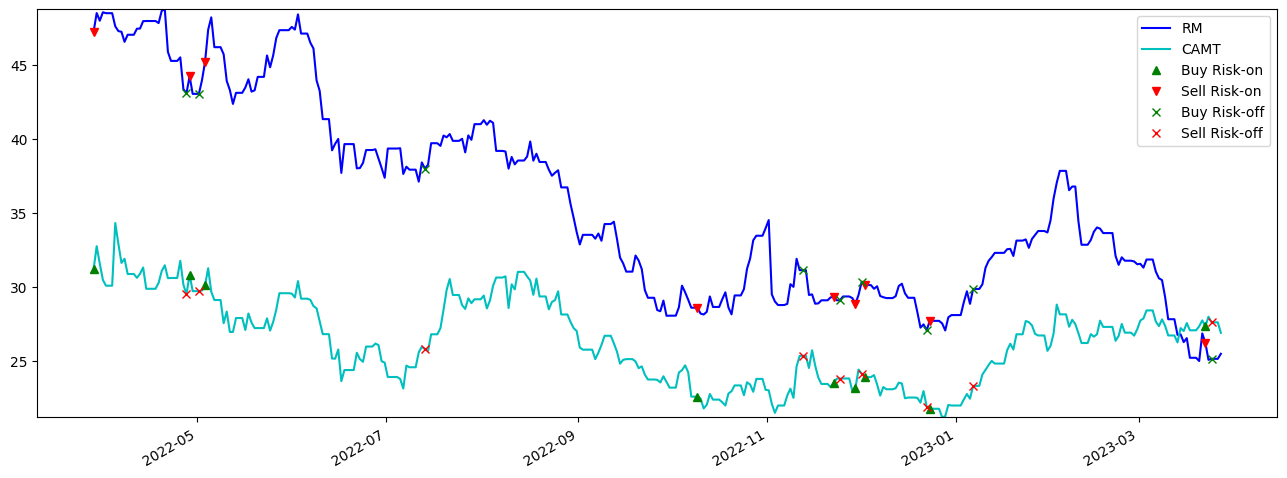

Total reward for this pair: 8.191520384176982
Total return for this pair: 9.373814537932205


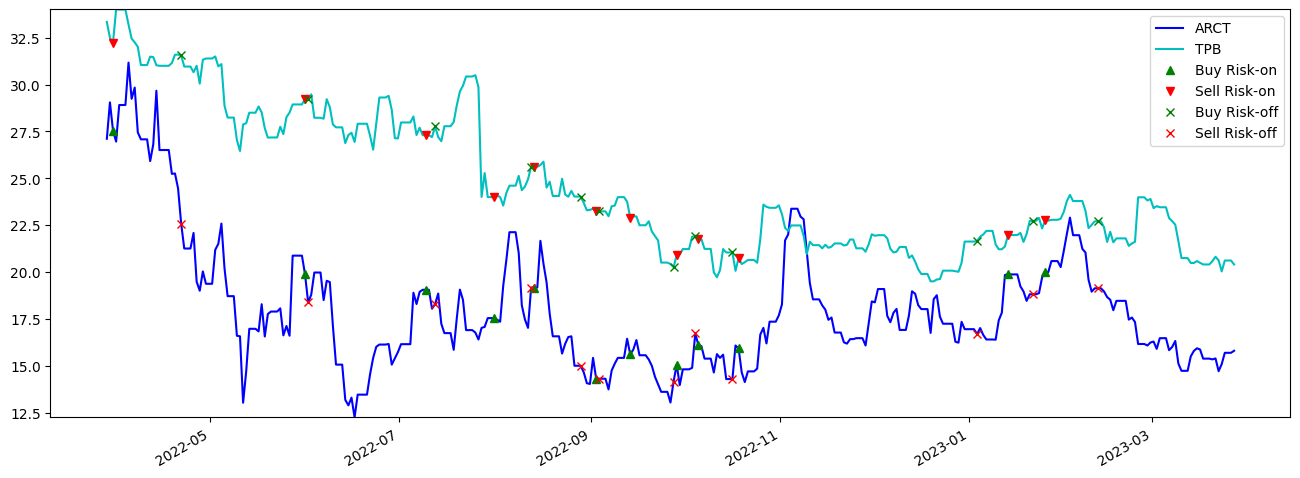

Total reward for this pair: -31.233492969048115
Total return for this pair: -30.541028239309682


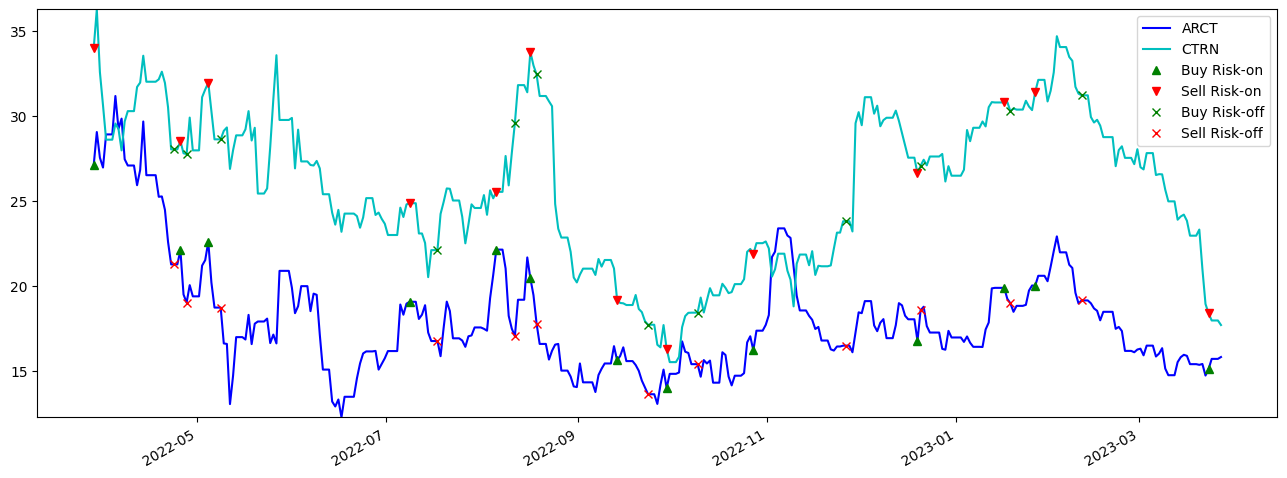

Total reward for this pair: -16.922711720869533
Total return for this pair: -15.331217656524306


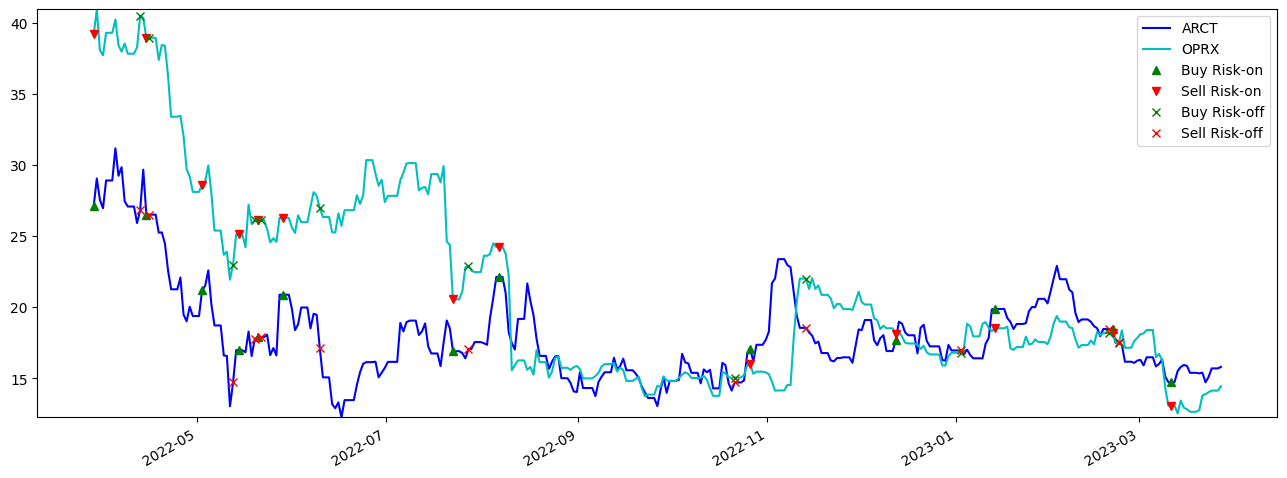

Total reward for this pair: -48.873516132733386
Total return for this pair: -47.24835829644128


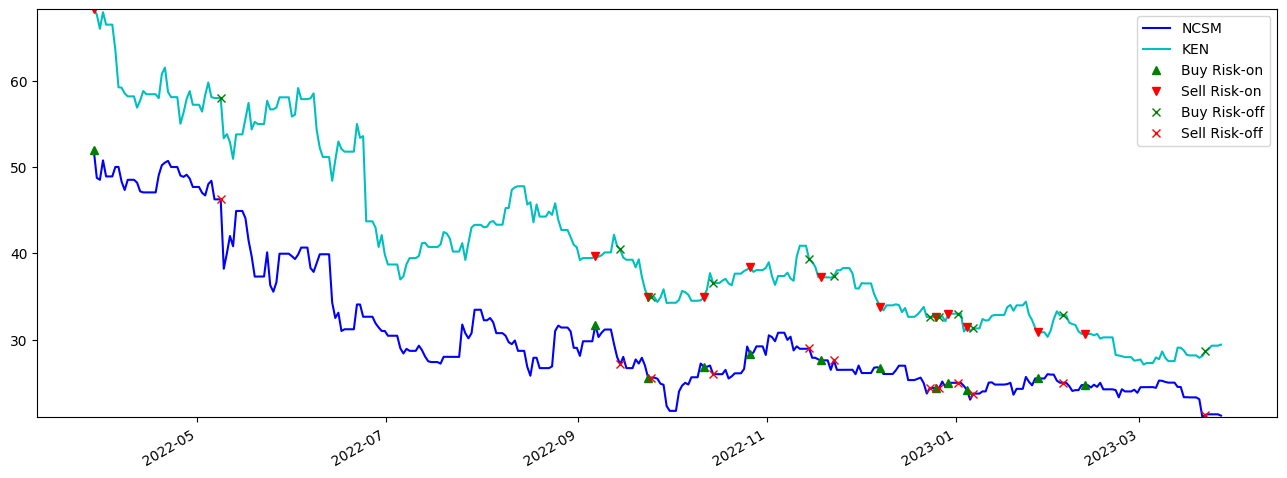

Total reward for this pair: -28.62310654371426
Total return for this pair: -27.897790986262542


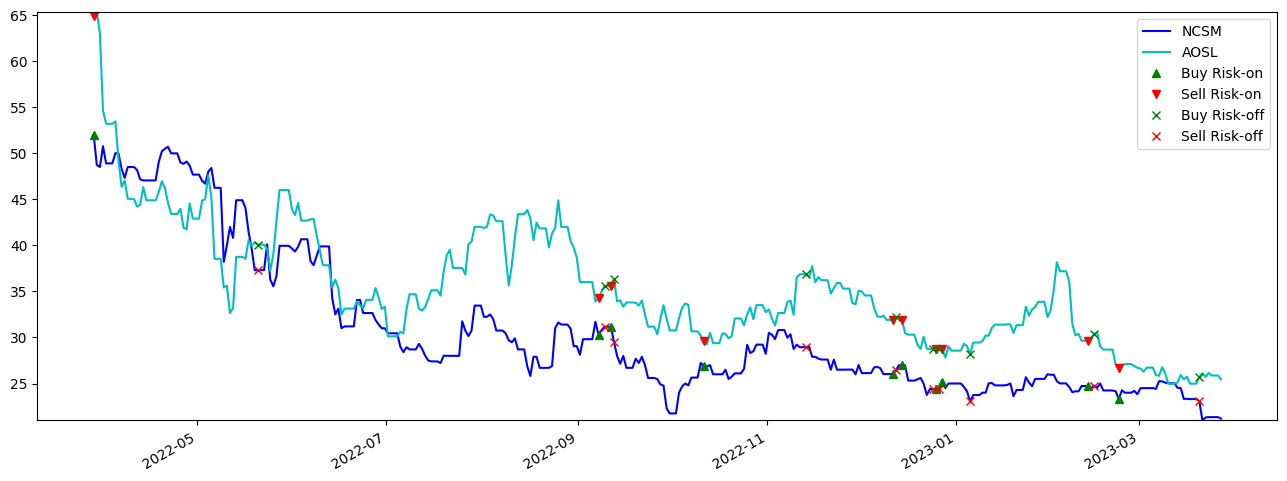

Total reward for this pair: -3.8631764459319635
Total return for this pair: -2.397539873386636


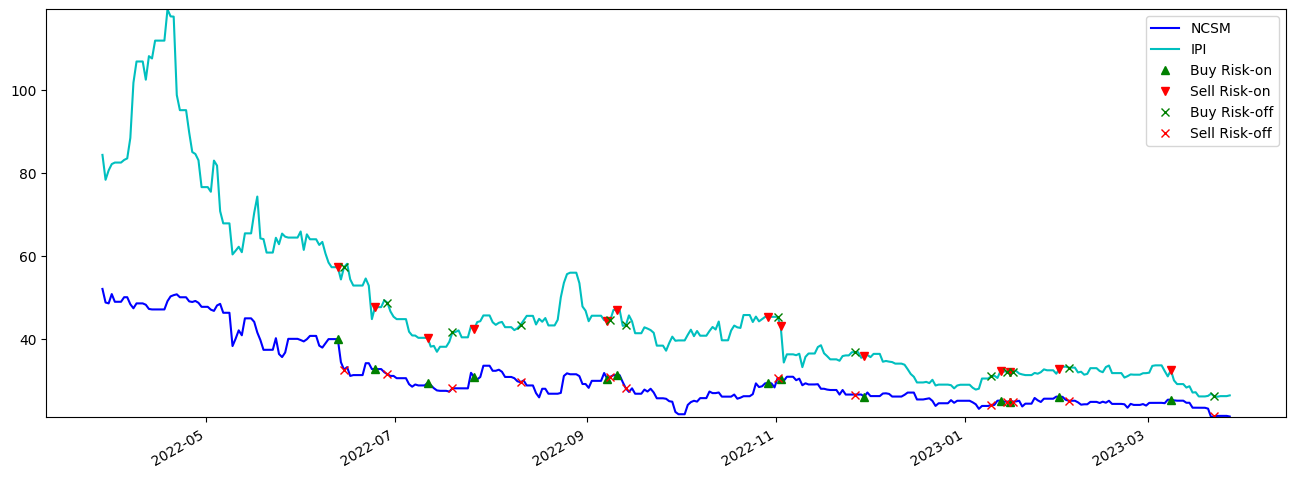

Total reward for this pair: -43.30343542818814
Total return for this pair: -41.55681819864496


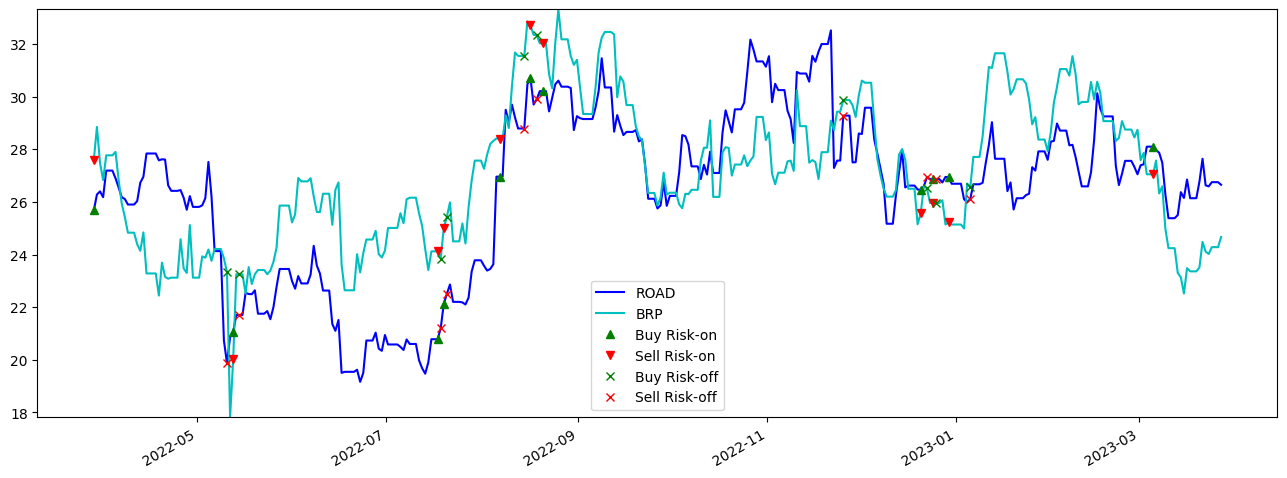

Total reward for this pair: -19.145447213115812
Total return for this pair: -18.42532246430296


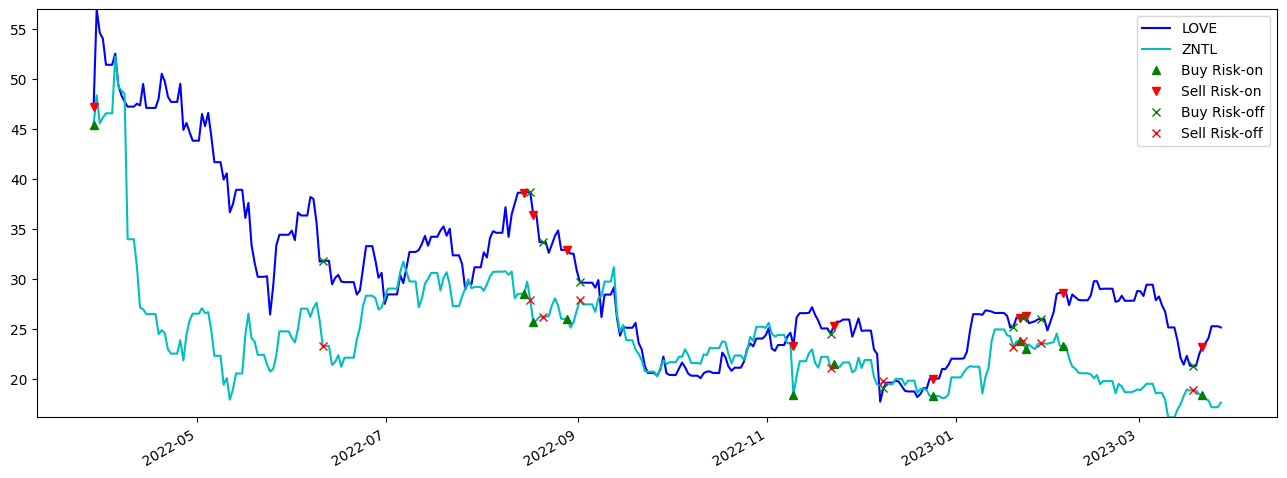

Total reward for this pair: 54.867506348332874
Total return for this pair: 56.46306111556633


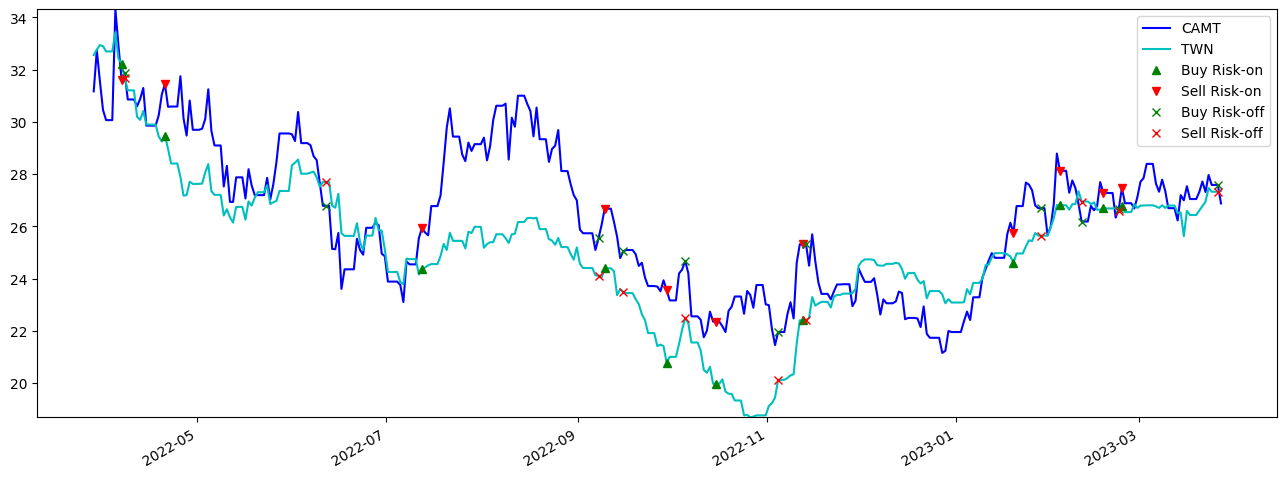

Total reward for this pair: 14.35350753195605
Total return for this pair: 14.906802035345432


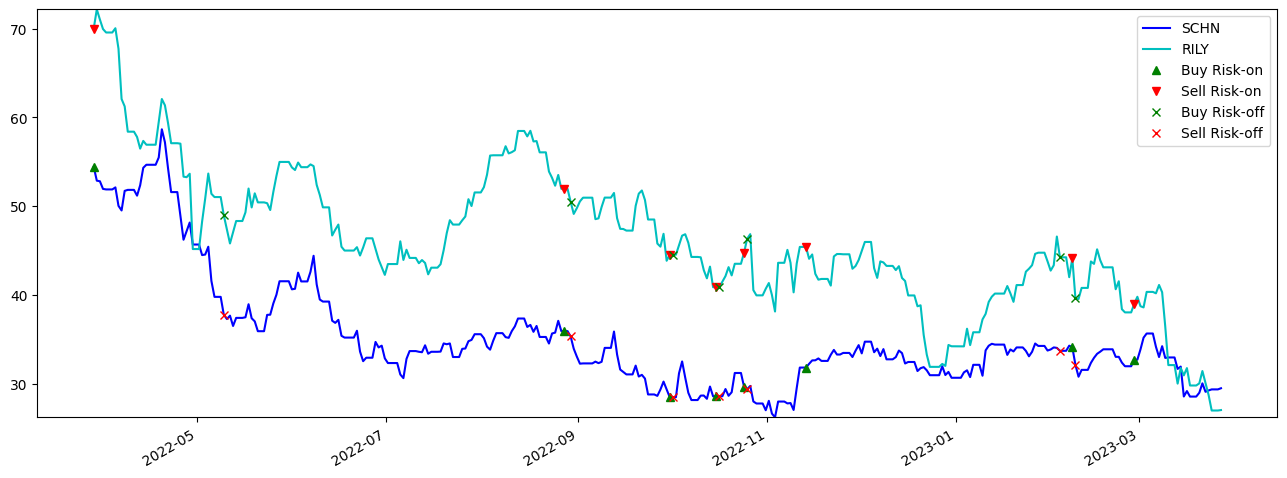

Total reward for this pair: -9.62899835407922
Total return for this pair: -9.19933520372032


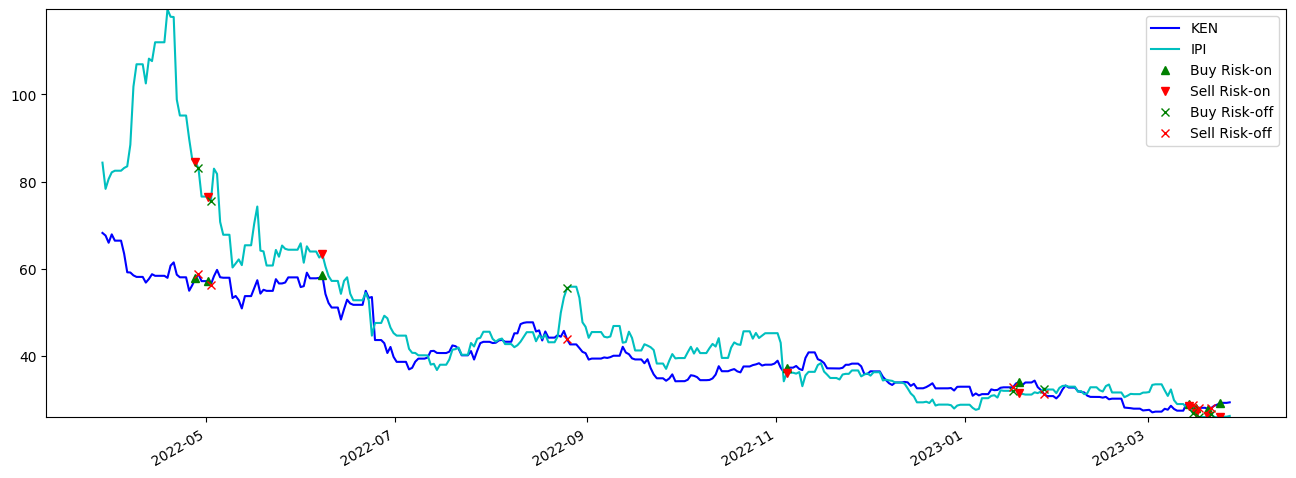

Total reward for this pair: -23.106633899564695
Total return for this pair: -22.486085930047665


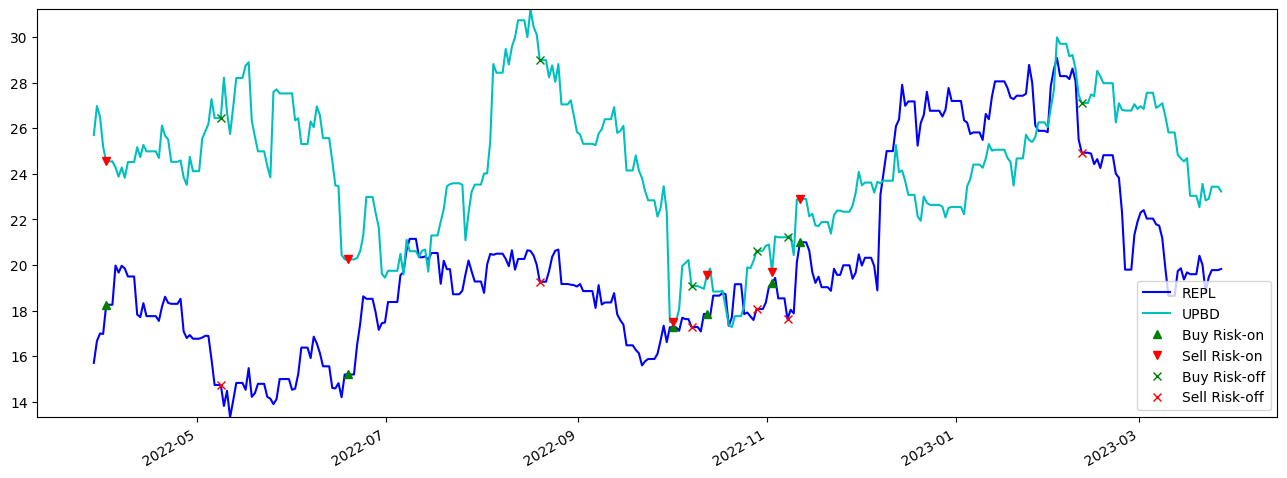

Total reward for this pair: -16.26483252729596
Total return for this pair: -15.477750408514758


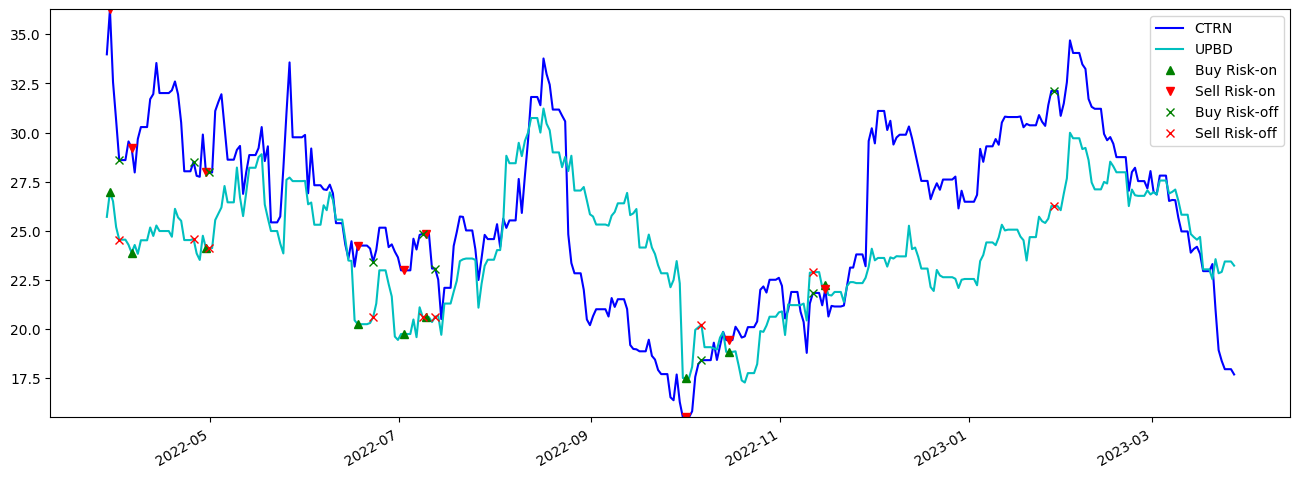

Total reward for this pair: 21.724952127591653
Total return for this pair: 23.447185880005726


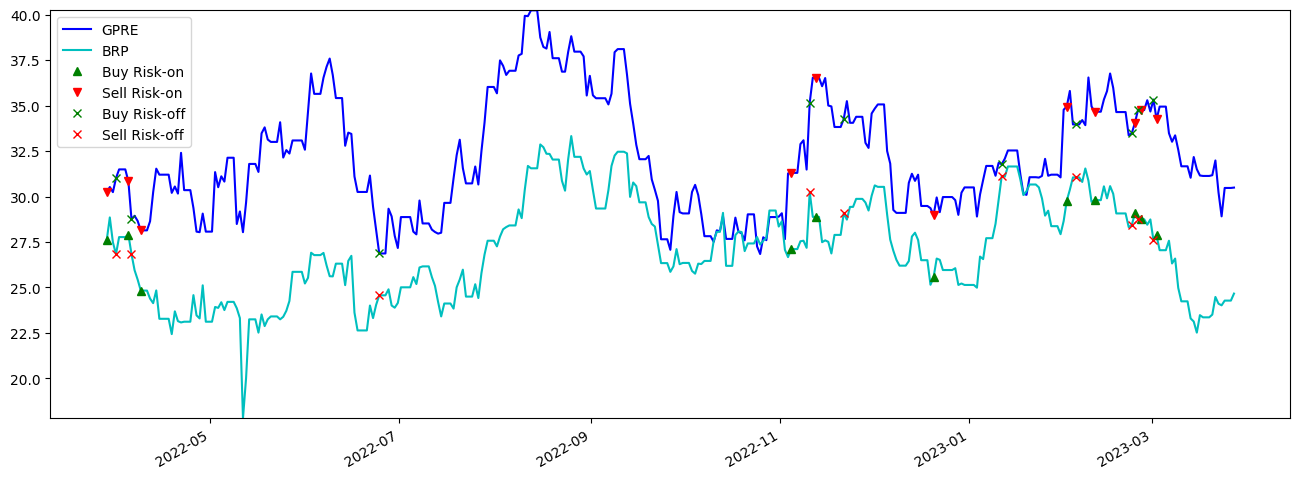

Total reward for this pair: 15.207093709680356
Total return for this pair: 15.95054102082285
Average overall rewards: -8.944046274716433
Average overall returns: -7.836127072022775


In [774]:
plot_function(policy_net, target_net, testenvs)

In [470]:
def plot_episodes(data_dict):
    # Convert dictionary to a Pandas DataFrame
    #df = pd.DataFrame.from_dict(data_dict, orient='columns')

    '''# Set the index of the DataFrame to the range of values n
    df.index = range(len(df))

    # Plot the data as a single line plot using Seaborn
    sns.lineplot(data=df)

    # Set the plot title and axis labels
    plt.title('Line plot of dictionary data')
    plt.xlabel('n')
    plt.ylabel('Values')

    # Display the plot
    plt.show()'''

    # Convert dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='columns').astype(float)
    #df['hue'] = range(1, len(df)+1)

    # Convert the data to long-form using melt()
    #df_long = pd.melt(df, id_vars=[0,1,2,3,4], var_name='variable', value_name='value')

    #for col in df.columns[0:5]:
    #    sns.lineplot(data=df_long[col], hue='value')
    
    # Plot the data as a line plot with trendlines using Seaborn
    #sns.lineplot(data=df_long, x='value', y=df_long.iloc[:,0:5], hue='variable')
    
    #this works
    sns.lineplot(data=df, palette=['blue'], dashes=False, legend=False)
    #sns.lineplot(data=df.iloc[:,-2:], dashes=False)
    
    
    # Melt the DataFrame to convert it to long format
    #df_melted = pd.melt(df, var_name='key', value_name='value').assign(value=lambda x: x['value'].to_numpy())

    # Plot the data as a line plot with trendlines using Seaborn
    #sns.lmplot(x=np.arange(len(df_melted)), y='value', data=df_melted)
    #sns.lineplot(x=np.arange(len(df)), y=df[0], data=df)
    #sns.lineplot(data=df.iloc[:,:5], hue='hue')

    # Set the plot title and axis labels
    plt.suptitle('Trendlines showing trends')
    plt.xlabel('n')
    #plt.ylabel('Values')

    # Display the plot
    plt.show()


    # Calculate the means for each column
    #means = df.mean()
    cumsum = df.cumsum()
    
    # get the index of the column with the highest cumulative sum
    highest_cumulative_sum = cumsum.sum().idxmax()

    print("Column with highest cumulative sum:", highest_cumulative_sum)

    # Plot the means as a line plot using Seaborn
    #sns.lineplot(data=means, color='blue')
    #Plot all cumulative sums
    sns.lineplot(data=cumsum, legend=False)#, palette=['pink'], dashes=False, legend=False)
    #Plot the highest cumulative sum only
    #sns.lineplot(data=cumsum[highest_cumulative_sum], legend=False)#, palette=['pink'], dashes=False, legend=False)

    # Set the plot title and axis labels
    plt.suptitle('Trendline showing change in cumulative returns across episodes')
    plt.xlabel('Steps in each episode')
    plt.ylabel('Cumulative return')

    # Display the plot
    plt.show()

    #Plot the highest cumulative sum only
    sns.lineplot(data=cumsum[highest_cumulative_sum], legend=False)#, palette=['pink'], dashes=False, legend=False)

    # Set the plot title and axis labels
    plt.suptitle('Trendline showing cumulative returns in the highest-return episode')
    plt.xlabel('Steps in the episode')
    plt.ylabel('Cumulative return')

    # Display the plot
    plt.show()


    #return df